In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from typing import List, Dict, Tuple, Any, Union
sys.path.append(os.path.abspath("../"))
from utils.general_utils import load_pickle, time2secs
from misc.all_label_generator import timeSeg2Labels

In [4]:
from src.metrics import getScores
from utils.general_utils import load_yaml

In [2]:
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_palette('Set1')
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# sns.set(font_scale=1.5)
# sns.set_style('ticks')
# sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman',
#                'axes.grid':True, 'grid.color':'.9', 'grid.linestyle':'--',
#                'axes.edgecolor':'.2', 'axes.linewidth':1.25, 'axes.facecolor':'white',
#                'axes.spines.left':False, 'axes.spines.bottom':False, 'axes.spines.right':False, 'axes.spines.top':False,
#                'xtick.bottom':True, 'ytick.left':True, 'xtick.color':'.15', 'ytick.color':'.15',
#                'axes.labelcolor':'.15', 'axes.labelsize':16.0, 'axes.labelweight':'bold',
#                'text.color':'.15', 'font.size':16.0, 'axes.titlesize':20.0, 'axes.titleweight':'bold',
#                'legend.frameon':True, 'legend.framealpha':1.0, 'legend.facecolor':'white',
#                'figure.facecolor':'white', 'savefig.facecolor':'white',
#                'axes.titlesize':20.0, 'axes.titleweight':'bold', 'axes.titlelocation':'center',
#                'axes.titlecolor':'.15', 'axes.titley':1.0, 'axes.titlex':0.5,
#                'figure.titlesize':20.0, 'figure.titleweight':'bold', 'figure.titlecolor':'.15',
#                'figure.titley':1.0, 'figure.titlex':0.5})

### Fill plotsss...

In [3]:
# arr = np.array([1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1])
# arr = np.array([1,1,1,0,0,1,1])
# arr = np.array([1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,0])
# arr = np.array([0,0,0,1,1,1,0,0,0,1,1,1])
# extract the start and end of all one's groups
# https://stackoverflow.com/questions/7352684/how-to-find-the-groups-of-consecutive-elements-from-an-array-in-numpy
# https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list

def getSegsFromOnes(flat_arr: Union[np.ndarray, list]):
    r"""
    Given a 1D array of 0s and 1s, return the start and end indices of the 1s.
    ---------
    Note: One can also use iterools.groupby() -> Much easier to use
    """
    if isinstance(flat_arr, list):
        flat_arr = np.array(flat_arr)
    diff_arr = np.diff(flat_arr)
    start_indices_of_ones = np.argwhere(diff_arr == 1).squeeze(axis=-1) + 1
    end_indices_of_ones = np.argwhere(diff_arr == -1).squeeze(axis=-1)
    if start_indices_of_ones[0] > end_indices_of_ones[0]:
        start_indices_of_ones = np.hstack(([0], start_indices_of_ones))
    if len(start_indices_of_ones) > len(end_indices_of_ones):
        end_indices_of_ones = np.hstack((end_indices_of_ones, [len(flat_arr)-1]))
    return start_indices_of_ones, end_indices_of_ones

def stitch_intervals(beg_idx_ones, end_idx_ones, shot_obj):
    time_intervals = {'beg': [], 'end': []}
    for beg_idx, end_idx in zip(beg_idx_ones, end_idx_ones):
        time_intervals['beg'].append(time2secs(shot_obj[beg_idx].time[0]))
        time_intervals['end'].append(time2secs(shot_obj[end_idx].time[1]))
    return time_intervals

def get_intervals_from_labels(series='24', season='S07', episode='E22', thresh=0.85):
    
    # import vid smooth labels and get the time interval of video shot...
    shot_obj = load_pickle(f"../data/{series}/{season}/{season}{episode}/encodings/vid_encodings/episode_OBJ.pkl")

    next_ep = "E%02d"%(int(episode[-2:]) + 1)

    vid_labels = load_pickle(f"../data/{series}/{season}/{season}{next_ep}/scores/vid_scores/recapVepisode/SL.pkl")
    beg_idx_ones, end_idx_ones = getSegsFromOnes((vid_labels[episode] > thresh).astype(np.int32))
    vid_smooth_intervals = stitch_intervals(beg_idx_ones, end_idx_ones, shot_obj)
    return vid_smooth_intervals

def get_intervals_from_pred(pred_arr, series='24', season='S07', episode='E22', thresh = 0.85):
    # import vid smooth labels and get the time interval of video shot...
    shot_obj = load_pickle(f"../data/{series}/{season}/{season}{episode}/encodings/vid_encodings/episode_OBJ.pkl")

    next_ep = "E%02d"%(int(episode[-2:]) + 1)

    beg_idx_ones, end_idx_ones = getSegsFromOnes((pred_arr.squeeze() > thresh).astype(np.int32))
    vid_smooth_intervals = stitch_intervals(beg_idx_ones, end_idx_ones, shot_obj)
    return vid_smooth_intervals

# def timeSeg2Labels(time_start: List[float],
#                    time_end: List[float],
#                    series_name: str,
#                    season: str,
#                    episode: str,
#                    inclusion_strategy: str = "mid",
#                    modality: str = "vid"
#                   ) -> np.ndarray:
#     """
#     Given a list of start and end times, returns shot-level labels
#     or utterance-level labels for respective modality.
#     -----------------------------------------------
#     Args:
#         - time_start: list of start times
#         - time_end: list of end times
#         - series_name: name of the series
#         - season: name of the season, e.g. S01
#         - episode: name of the episode, e.g. E01
#         - inclusion_strategy: strategy to include the time segment
#             - `mid`: include the segment if the mid-point of the segment is
#               within the time interval
#             - `end`: include the segment if the end of the segment is within
#               the time interval
#         - modality: modality for which labels are to be generated
    
#     Returns:
#         - labels: array of labels
#     """
#     # THIS ONE ALREADY IMPORTED from all_label_generator file

**LINK to InterPOlation: https://docs.scipy.org/doc/scipy/tutorial/interpolate/1D.html#piecewise-linear-interpolation**

- `Akima1DInterpolator` and `PchipInterpolator` are both interpolation methods that use piecewise cubic polynomials to fit data. However, they differ in how they construct the polynomials.
- `Akima1DInterpolator` uses a continuously differentiable sub-spline built from piecewise cubic polynomials [1](https://www.mathworks.com/help/matlab/ref/makima.html) [2](https://docs.scipy.org/doc/scipy/tutorial/interpolate/1D.html).
- On the other hand, `PchipInterpolator` uses monotonic cubic splines to find the value of new points [3](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Akima1DInterpolator.html).
- When the underlying function is oscillatory, spline and makima capture the movement between points better than pchip, which is aggressively flattened near the extrema .
- **Therefore, if the data is oscillatory, `Akima1DInterpolator` may be a better choice than `PchipInterpolator`.**
- However, if the data is not oscillatory, `PchipInterpolator` may be a better choice than `Akima1DInterpolator`.

In [4]:
from scipy.interpolate import interp1d, CubicSpline, PchipInterpolator, Akima1DInterpolator

In [5]:
# array = np.array([1.0, 2.5, 3.7, 4.2, 5.8, 6.4])
# intervals = [(1.0, 3.0), (4.0, 6.0)]

def find_interval(array, intervals):
    """given real-line bounded intervals and some discrete numbers, try to output discrete booleans which falls in/out."""
    result = np.zeros(array.shape, dtype=bool)
    for interval in intervals:
        result = np.logical_or(result, np.logical_and(array >= interval[0], array <= interval[1]))
    return result

# print(find_interval(array, intervals))

def plot_intervals(x, y1, y2, bins, savefig=False, fig_name='test.svg', color='#023047', fig=None):
    x_patch = find_interval(x, bins)
    if fig is None:
        fig = plt.figure(figsize=(18, 0.25), dpi=500)
    plt.plot(x, y1, x, y2, color='#292929')
    plt.fill_between(x, y1, y2, where=x_patch, color=color) # alpha=0.5
    # connect at first and last point
    plt.plot([x[0], x[0]], [y1[0], y2[0]], color='#292929') # alpha=0.5
    plt.plot([x[-1], x[-1]], [y1[-1], y2[-1]], color='#292929') # alpha=0.5
    # remove ticks, labels, etc. and axes
    plt.xticks([]); plt.yticks([]); plt.axis('off')
    # plt.gca().spines['top'].set_edgecolor('#525252')
    # plt.gca().spines['bottom'].set_edgecolor('#525252')
    # plt.gca().spines['left'].set_edgecolor('#525252')
    # plt.gca().spines['right'].set_edgecolor('#525252')
    # plt.gca().spines['top'].set_visible(False)
    # fig.legend(['y1', 'y2', 'bins'], loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.5))
    if savefig:
        fig.savefig(fig_name, bbox_inches='tight', pad_inches=0, transparent=True)
    # fig.tight_layout(rect=[0, 0, 0.97, 1])
    fig.tight_layout(pad=0)
    if fig is None:
        plt.show()
    # fig.clear()
    # plt.close()
    return fig
def sec2time(time): return f"00:{time//60:02.0f}:{time%60:02.0f}"

# *************************************************** MODEL PREDICTION ***************************************************

def plot_model_pred(vid_model_preds, series:str = '24', season:str = 'S03', episode:str = 'E02', save_fig:bool=False):
    # Extract video time
    shot_obj = load_pickle(f"../data/{series}/{season}/{season}{episode}/encodings/vid_encodings/episode_OBJ.pkl")
    time_arr = np.array([time2secs(shot_obj[0].time[0])] + \
                        [np.mean(list(map(time2secs, shot_obj[t].time))) for t in range(len(shot_obj))] + \
                        [time2secs(shot_obj[-1].time[-1])])

    xs = np.arange(time_arr[0], time_arr[-1], 0.5)
    # video model predictions
    # vid_model_preds = np.load(f"../reports/{season}{episode}_vid_yhat.npy")
    vid_model_preds = np.hstack((vid_model_preds[0], vid_model_preds, vid_model_preds[-1]))
    # cs = interp1d(time_arr, vid_model_preds, kind="cubic")
    # cs = CubicSpline(time_arr, vid_model_preds) # same as interp1d kind = 'cubic'
    cs = Akima1DInterpolator(time_arr, vid_model_preds)
    interpolated_vals = cs(xs)
    # cs = PchipInterpolator(time_arr, vid_model_preds)
    fig = plt.figure(figsize = (18, 2), dpi=300)
    plt.plot(xs, interpolated_vals)
    # plot specifics
    plt.ylim(min(interpolated_vals)-0.02, max(interpolated_vals)+0.02)
    plt.xlim(min(xs), max(xs))
    # plt.xlabel("Time (s)")
    # plt.ylabel("Importance Score")
    # plt.legend(loc='upper right', bbox_to_anchor=(1, 1.25), ncol=3)
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # plt.title(f"Plot for {series}'s {season}{episode} (Video shot importance scores)")
    plt.grid()
    # plt.axis('off')
    fig.tight_layout(pad=0)
    if save_fig:
        fig.savefig(f"../plots/vid_{series}-{season}{episode}.pdf", bbox_inches='tight')#, transparent=True
    # plt.show()
    plt.show()

def plot_model_pred_intervals(x, y1, bins, savefig=False, fig_name='test.svg', color='#023047', fig=None):
    x_patch = find_interval(x, bins)
    if fig is None:
        fig = plt.figure(figsize=(9, 1), dpi=500)
    plt.plot(x, y1, linewidth=0.0)# color='white', 
    plt.fill_between(x, y1, where=x_patch, color=color) # alpha=0.5, edgecolor=None, linewidth=0.0, facecolor="none", hatch="X", 
    # remove ticks, labels, etc. and axes
    plt.xticks([]); plt.yticks([]); plt.axis('off')
    # fig.legend(['y1', 'y2', 'bins'], loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.5))
    if savefig:
        fig.savefig(fig_name, bbox_inches='tight', pad_inches=0, transparent=True)
    # fig.tight_layout(rect=[0, 0, 0.97, 1])
    fig.tight_layout(pad=0)
    if fig is None:
        plt.show()
    # fig.clear()
    # plt.close()
    return fig

def interpVidPred(vid_model_preds, series:str = '24', season:str = 'S03', episode:str = 'E02'):
    # Extract video time
    shot_obj = load_pickle(f"../data/{series}/{season}/{season}{episode}/encodings/vid_encodings/episode_OBJ.pkl")
    time_arr = np.array([time2secs(shot_obj[0].time[0])] + \
                        [np.mean(list(map(time2secs, shot_obj[t].time))) for t in range(len(shot_obj))] + \
                        [time2secs(shot_obj[-1].time[-1])])

    xs = np.arange(time_arr[0], time_arr[-1], 0.5)
    # video model predictions
    # vid_model_preds = np.load(f"../reports/{season}{episode}_vid_yhat.npy")
    vid_model_preds = np.hstack((vid_model_preds[0], vid_model_preds, vid_model_preds[-1]))
    # cs = interp1d(time_arr, vid_model_preds, kind="cubic")
    # cs = CubicSpline(time_arr, vid_model_preds) # same as interp1d kind = 'cubic'
    cs = Akima1DInterpolator(time_arr, vid_model_preds)
    interpolated_vals = cs(xs)
    return xs[1:-1], interpolated_vals[1:-1]

In [6]:
# plot_model_pred(vid_pred, series = '24', season = 'S06', episode = 'E22')

### **Qualitative Analysis...**

#### **S06E22**

In [14]:
# load model predictions...
# r = RoBERTa
eps = "S06E22"
vid_pred = np.load(f"../reports/{eps}_vidr_yhat.npy").squeeze()
vid_pred[vid_pred >= 0.6] -= 0.315
vid_target = np.load(f"../reports/{eps}_vidr_targets.npy").squeeze()
dia_pred = np.load(f"../reports/{eps}_diar_yhat.npy").squeeze()
dia_target = np.load(f"../reports/{eps}_diar_targets.npy").squeeze()

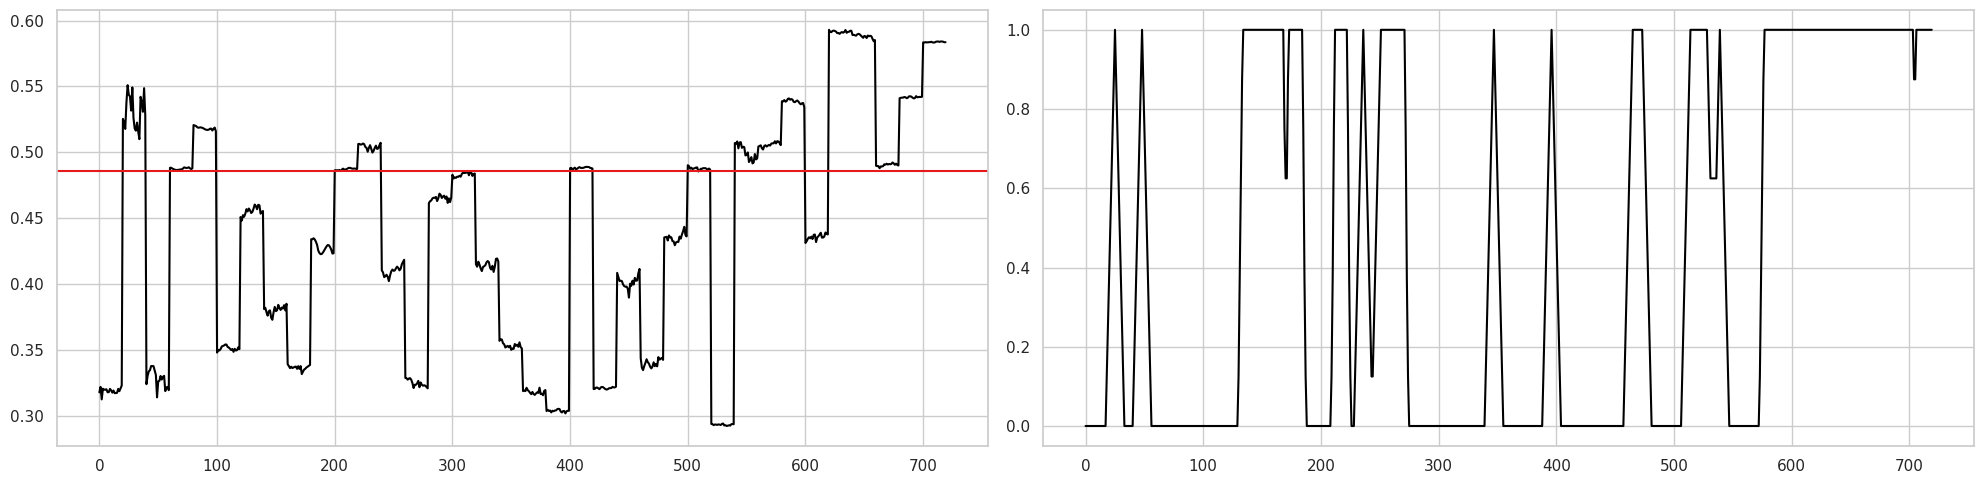

In [13]:
# fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))
# ax[0].plot(np.arange(len(vid_pred)), vid_pred, color='black'); ax[0].axhline(y=0.486)
# ax[1].plot(np.arange(len(vid_target)), vid_target, color='black')
# fig.tight_layout()
# plt.show()

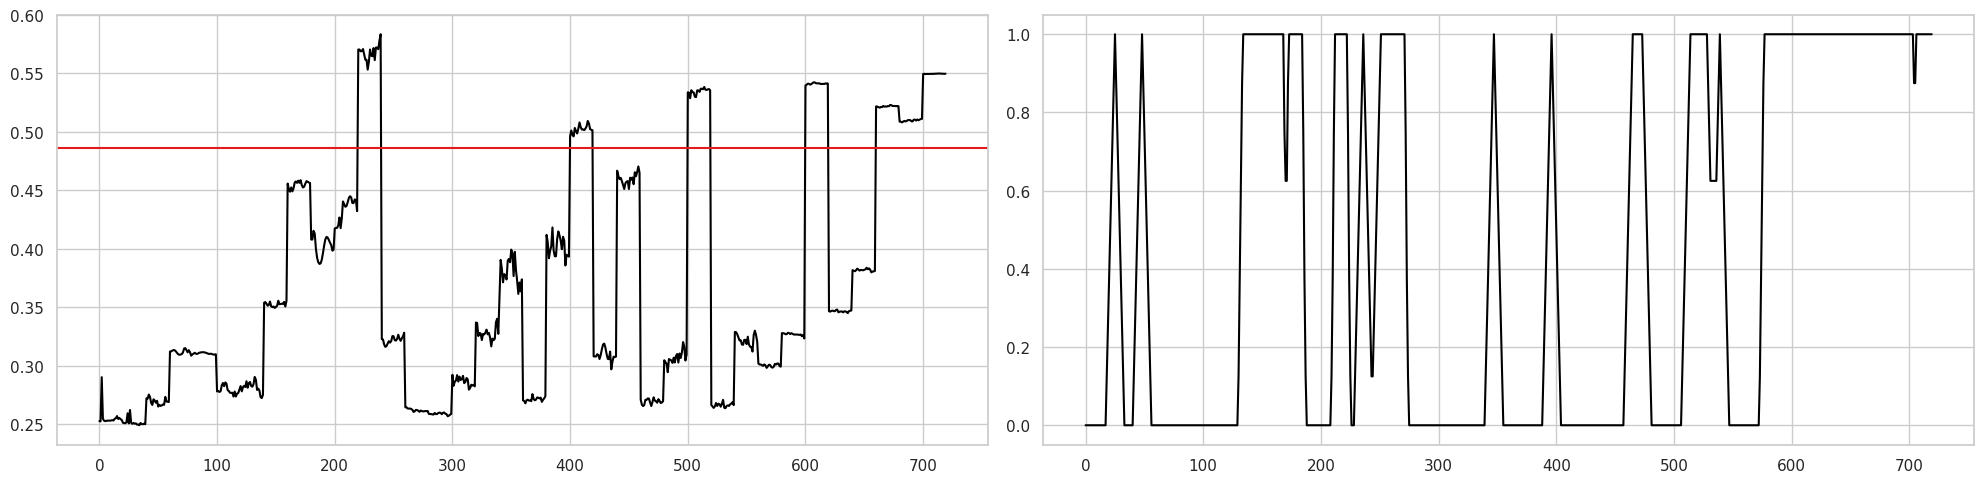

In [15]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))
ax[0].plot(np.arange(len(vid_pred)), vid_pred, color='black'); ax[0].axhline(y=0.486)
ax[1].plot(np.arange(len(vid_target)), vid_target, color='black')
fig.tight_layout()
plt.show()

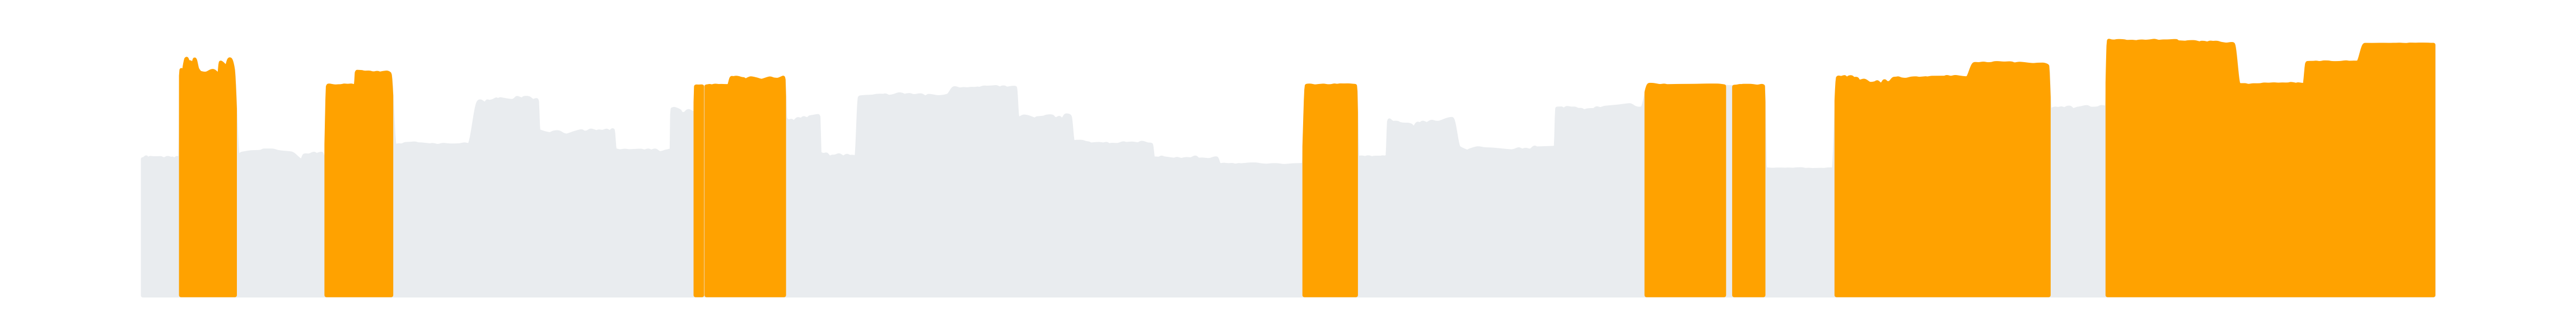

In [57]:
x_axis, interp_pred = interpVidPred(vid_pred, series = '24', season = 'S06', episode = 'E22')
pred_bins = get_intervals_from_pred(vid_pred, series='24', season='S06', episode='E22', thresh = 0.486)
pred_bins = [[b,e] for b, e in zip(pred_bins['beg'], pred_bins['end'])]
fig = plot_model_pred_intervals(x_axis, interp_pred, [[x_axis[0], x_axis[-1]]], color='#e9ecef')
_ = plot_model_pred_intervals(x_axis, interp_pred, pred_bins, savefig=True, fig_name='../plots/QA_S06E22.svg', color='#ffa200', fig=fig) #F1935C, f5895c, F8A673

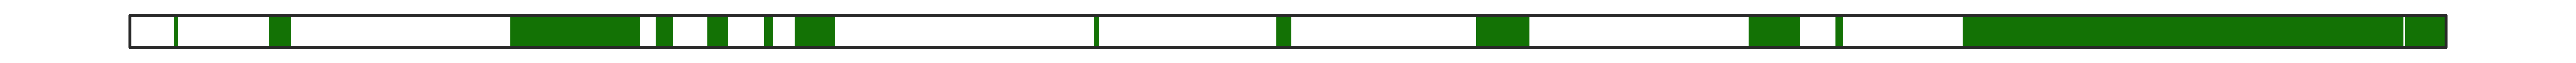

In [50]:
y1 = np.repeat(0, len(x_axis))
y2 = np.repeat(3, len(x_axis))
gt_bins = get_intervals_from_labels(series='24', season='S06', episode='E22', thresh=0.95)
gt_bins = [[b, e] for b, e in zip(gt_bins['beg'], gt_bins['end'])]
_ = plot_intervals(x_axis, y1, y2, gt_bins, savefig=True, fig_name="../plots/QA_S06E22_G.svg", color='#137205') # "FB9F69" "FBB98D" "ff9505"

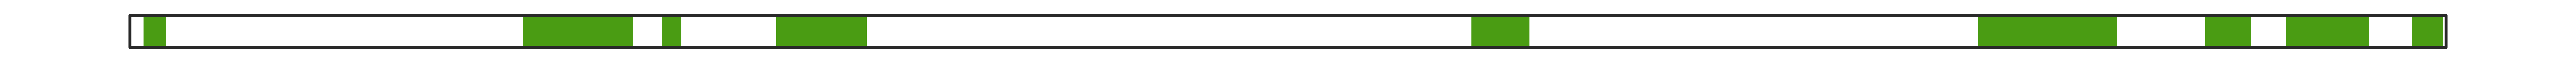

In [51]:
fandom_bins = {'beg': [157.553, 553.532, 698.844, 818.422, 1543.855, 2072.883, 2309.537, 2394.204, 2525.544],
 'end': [179.617, 667.02, 717.863, 911.181, 1602.83, 2216.276, 2356.208, 2478.956, 2556.366]}
fandom_bins = [[b, e] for b, e in zip(fandom_bins['beg'], fandom_bins['end'])]
_ = plot_intervals(x_axis, y1, y2, fandom_bins, savefig=True, fig_name="../plots/QA_S06E22_F.svg", color='#4A9C13')

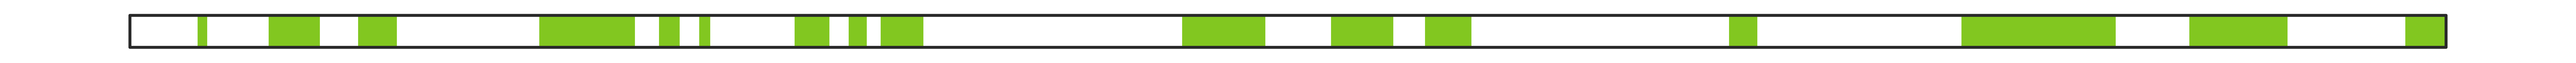

In [52]:
human_bins = {'beg': [214.068, 288.017, 381.485, 570.925, 695.883, 737.675, 837.232, 893.747, 927.364, 1241.678, 1397.125, 1495.223, 1812.457, 2055.157, 2293.312, 2518.662],
              'end': [222.576, 340.402, 420.566, 669.273, 715.944, 747.601, 872.184, 911.181, 970.282, 1327.055, 1460.48, 1542.27, 1840.901, 2214.608, 2394.162, 2561.413]} 
human_bins = [[b, e] for b, e in zip(human_bins['beg'], human_bins['end'])]
_ = plot_intervals(x_axis, y1, y2, human_bins, savefig=True, fig_name="../plots/QA_S06E22_H.svg", color='#82C720')

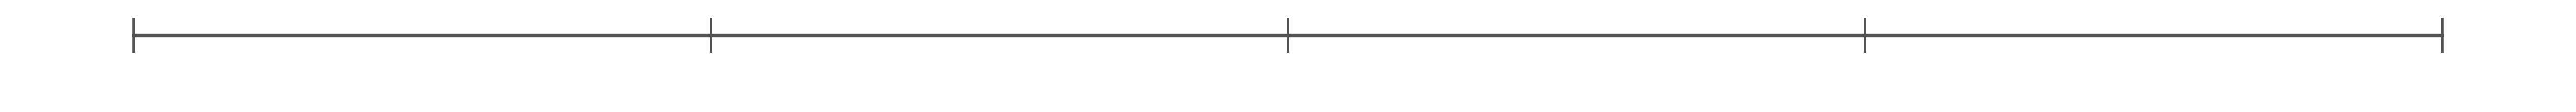

In [31]:
## PLOT x-axis line
x_axis = np.arange(140, 60*43 + 31, 600)
y1 = np.repeat(0, len(x_axis))
y2 = np.repeat(1, len(x_axis))
fig = plt.figure(figsize=(18, 0.25), dpi=400)
plt.plot(x_axis, y1, color='#525252')
# plt.xticks(ticks=np.arange(120, 60*43 + 10, 240), labels=np.arange(2, 44, 4))
# plt.axhline(0, color='black')
# plt.xlim(2, 43.16)
plt.xticks(ticks=x_axis, labels=np.arange(2, 44, 10), fontsize=7, color='#ffffff')#; plt.xticks([])
plt.yticks([]); plt.grid(color='#525252')#; plt.axis('off')
# plt.grid(axis='y')
# current_font_size = plt.rcParams['font.size']
# plt.rcParams.update({'font.size': 1})
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
fig.savefig("../plots/x-axis.svg", bbox_inches='tight', pad_inches=0, transparent=True)#, transparent=True
plt.show()
# plt.rcParams.update({'font.size': current_font_size})

In [17]:
gt_bins_time = [[sec2time(ele[0]), sec2time(ele[1])] for ele in gt_bins]
print(gt_bins_time)

[['00:03:10', '00:03:12'], ['00:04:48', '00:05:10'], ['00:09:01', '00:11:15'], ['00:11:32', '00:11:49'], ['00:12:26', '00:12:46'], ['00:13:26', '00:13:33'], ['00:13:57', '00:14:38'], ['00:19:10', '00:19:14'], ['00:22:20', '00:22:34'], ['00:25:49', '00:26:43'], ['00:30:33', '00:31:25'], ['00:32:04', '00:32:10'], ['00:34:17', '00:41:55'], ['00:41:59', '00:42:41']]


In [19]:
pred_bins_time = [(sec2time(ele[0]), sec2time(ele[1])) for ele in pred_bins]
print(pred_bins_time)

[('00:03:03', '00:04:01'), ('00:05:37', '00:06:46'), ('00:12:06', '00:12:14'), ('00:12:18', '00:13:40'), ('00:22:49', '00:23:44'), ('00:28:49', '00:30:12'), ('00:30:22', '00:30:54'), ('00:32:10', '00:35:55'), ('00:36:56', '00:42:41')]


**S06E20**

In [81]:
# load model predictions...
# r = RoBERTa
eps = "S06E20"
vid_pred = np.load(f"../reports/{eps}_vid_yhat.npy").squeeze()
vid_pred[-125:][vid_pred[-125:] < 0.8] -= 0.315
vid_target = np.load(f"../reports/{eps}_vid_targets.npy").squeeze()
dia_pred = np.load(f"../reports/{eps}_dia_yhat.npy").squeeze()
dia_target = np.load(f"../reports/{eps}_dia_targets.npy").squeeze()

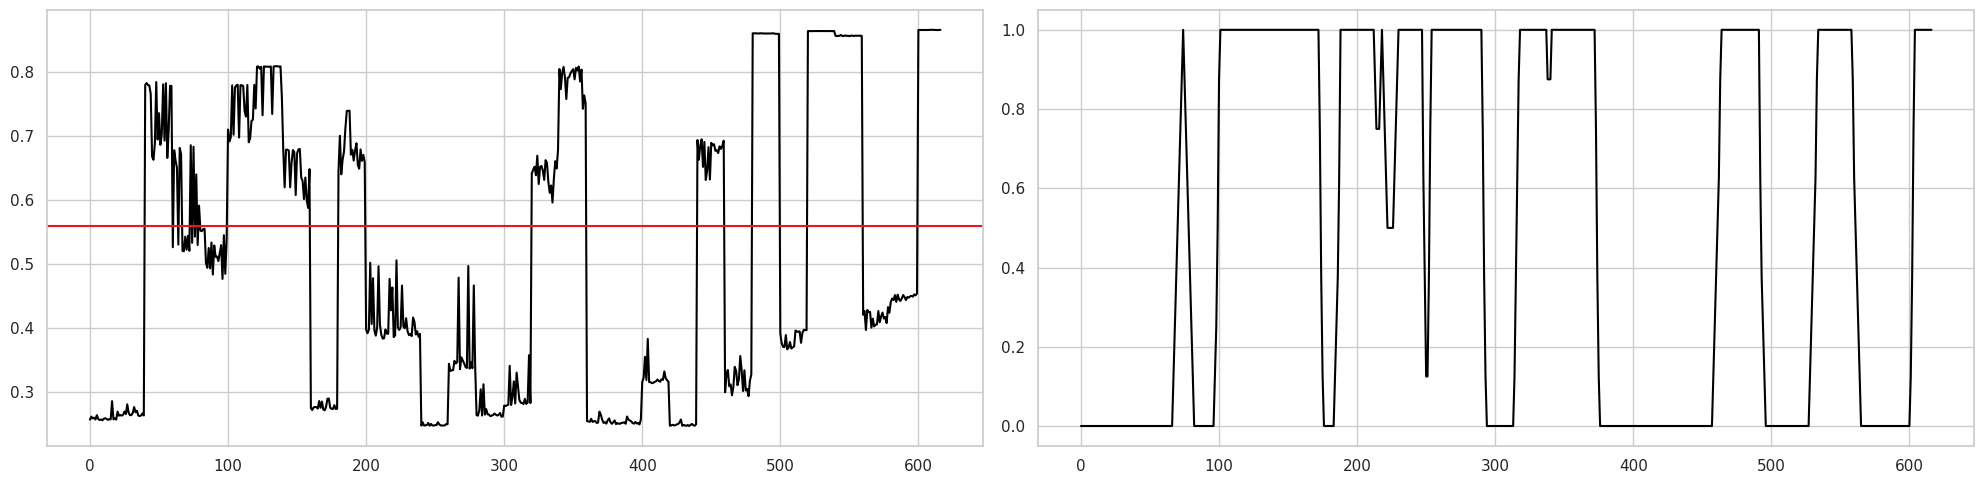

In [82]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))
ax[0].plot(np.arange(len(vid_pred)), vid_pred, color='black'); ax[0].axhline(y=0.56)
ax[1].plot(np.arange(len(vid_target)), vid_target, color='black')
fig.tight_layout()
plt.show()

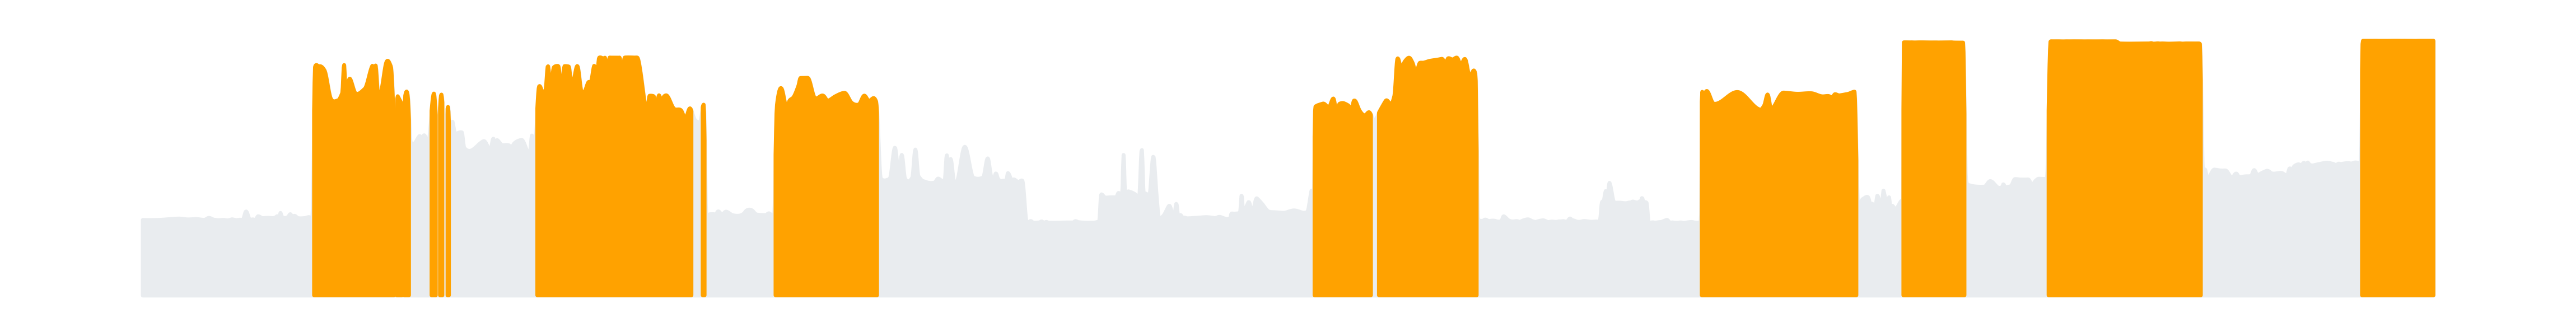

In [83]:
x_axis, interp_pred = interpVidPred(vid_pred, series = '24', season = 'S06', episode = 'E20')
pred_bins = get_intervals_from_pred(vid_pred, series='24', season='S06', episode='E20', thresh = 0.6)
pred_bins = [[b,e] for b, e in zip(pred_bins['beg'], pred_bins['end'])]
fig = plot_model_pred_intervals(x_axis, interp_pred, [[x_axis[0], x_axis[-1]]], color='#e9ecef')
_ = plot_model_pred_intervals(x_axis, interp_pred, pred_bins, savefig=True, fig_name='../plots/QA_S06E20.svg', color='#ffa200', fig=fig) #F1935C, f5895c, F8A673

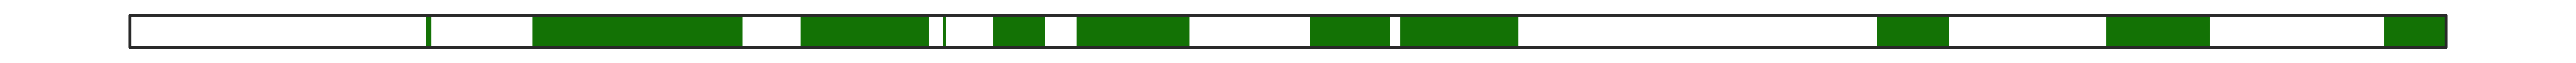

In [84]:
y1 = np.repeat(0, len(x_axis))
y2 = np.repeat(3, len(x_axis))
gt_bins = get_intervals_from_labels(series='24', season='S06', episode='E20', thresh=0.95)
gt_bins = [[b, e] for b, e in zip(gt_bins['beg'], gt_bins['end'])]
_ = plot_intervals(x_axis, y1, y2, gt_bins, savefig=True, fig_name="../plots/QA_S06E20_G.svg", color='#137205') # "FB9F69" "FBB98D" "ff9505"

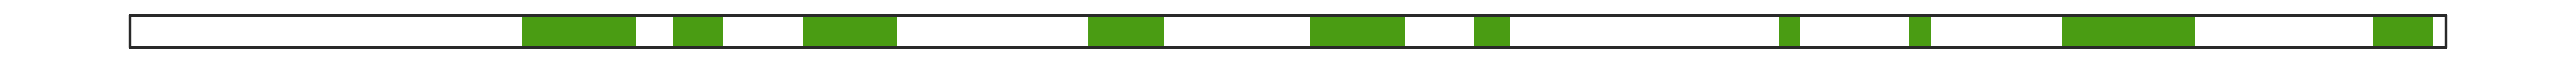

In [85]:
fandom_bins = {'beg': [557.495, 716.195, 852.956, 1153.382, 1386.489, 1558.995, 1879.857, 2016.786, 2178.364, 2505.149],
               'end': [675.654, 767.537, 950.262, 1231.793, 1484.837, 1595.114, 1900.586, 2038.724, 2316.71, 2567.21]}
fandom_bins = [[b, e] for b, e in zip(fandom_bins['beg'], fandom_bins['end'])]
_ = plot_intervals(x_axis, y1, y2, fandom_bins, savefig=True, fig_name="../plots/QA_S06E20_F.svg", color='#4A9C13')

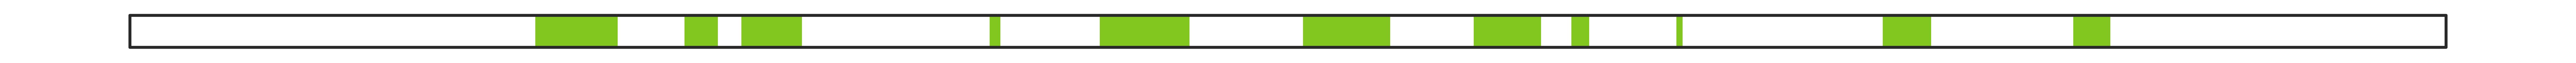

In [86]:
human_bins = {'beg': [571.3, 728.374, 788.058, 1049.194, 1165.519, 1379.399, 1558.995, 1661.806, 1772.417, 1989.217, 2189.75],
              'end': [656.385, 762.032, 850.495, 1059.204, 1258.445, 1469.113, 1628.231, 1678.906, 1777.046, 2038.724, 2227.413]} 
human_bins = [[b, e] for b, e in zip(human_bins['beg'], human_bins['end'])]
_ = plot_intervals(x_axis, y1, y2, human_bins, savefig=True, fig_name="../plots/QA_S06E20_H.svg", color='#82C720')

In [87]:
pred_bins_time = [(sec2time(ele[0]), sec2time(ele[1])) for ele in pred_bins]
print(pred_bins_time)

[('00:05:26', '00:06:52'), ('00:06:54', '00:07:00'), ('00:07:02', '00:07:08'), ('00:07:31', '00:07:36'), ('00:07:40', '00:07:43'), ('00:07:48', '00:07:50'), ('00:09:24', '00:12:08'), ('00:12:20', '00:12:22'), ('00:13:37', '00:15:26'), ('00:23:11', '00:24:11'), ('00:24:19', '00:26:04'), ('00:30:03', '00:32:48'), ('00:33:37', '00:34:43'), ('00:36:12', '00:38:54'), ('00:41:45', '00:43:02')]


**S07E22**

In [88]:
# load model predictions...
# r = RoBERTa
eps = "S07E22"
vid_pred = np.load(f"../reports/{eps}_vid_yhat.npy").squeeze()
# vid_pred[vid_pred >= 0.6] -= 0.315
vid_target = np.load(f"../reports/{eps}_vid_targets.npy").squeeze()
dia_pred = np.load(f"../reports/{eps}_dia_yhat.npy").squeeze()
dia_target = np.load(f"../reports/{eps}_dia_targets.npy").squeeze()

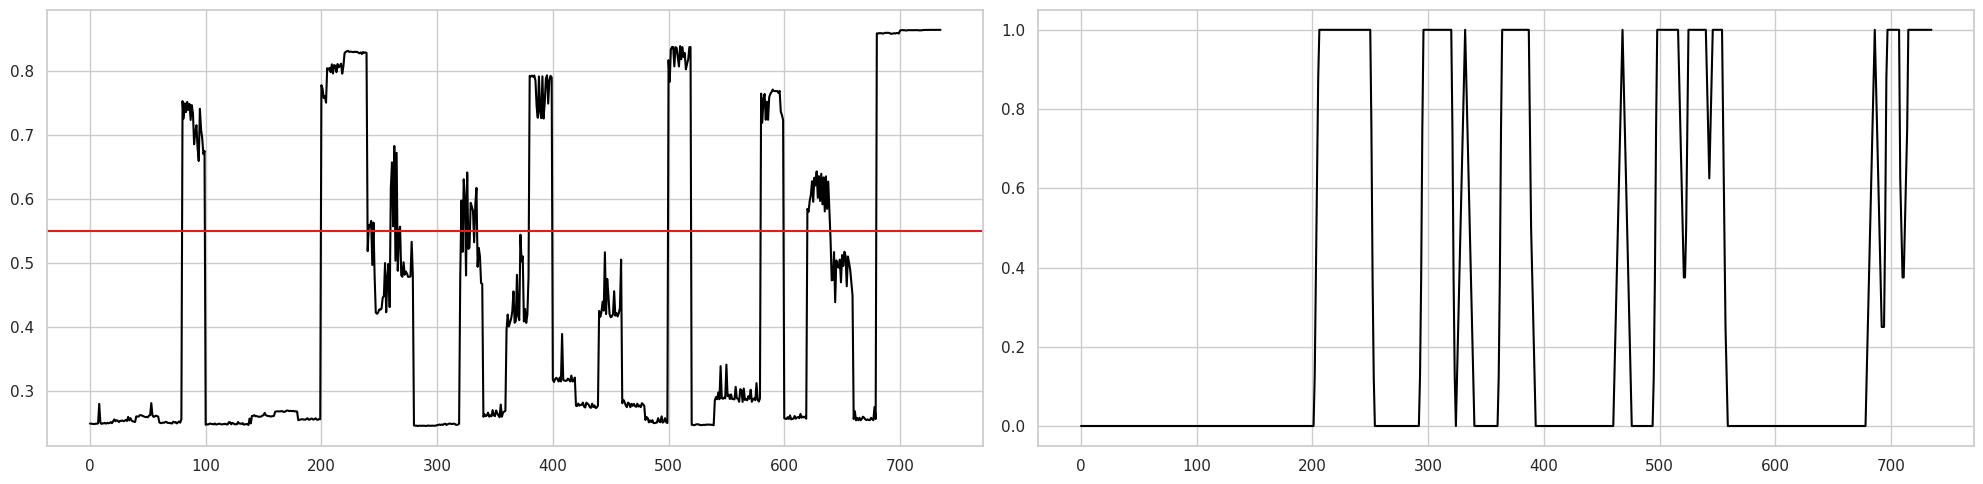

In [89]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))
ax[0].plot(np.arange(len(vid_pred)), vid_pred, color='black'); ax[0].axhline(y=0.55)
ax[1].plot(np.arange(len(vid_target)), vid_target, color='black')
fig.tight_layout()
plt.show()

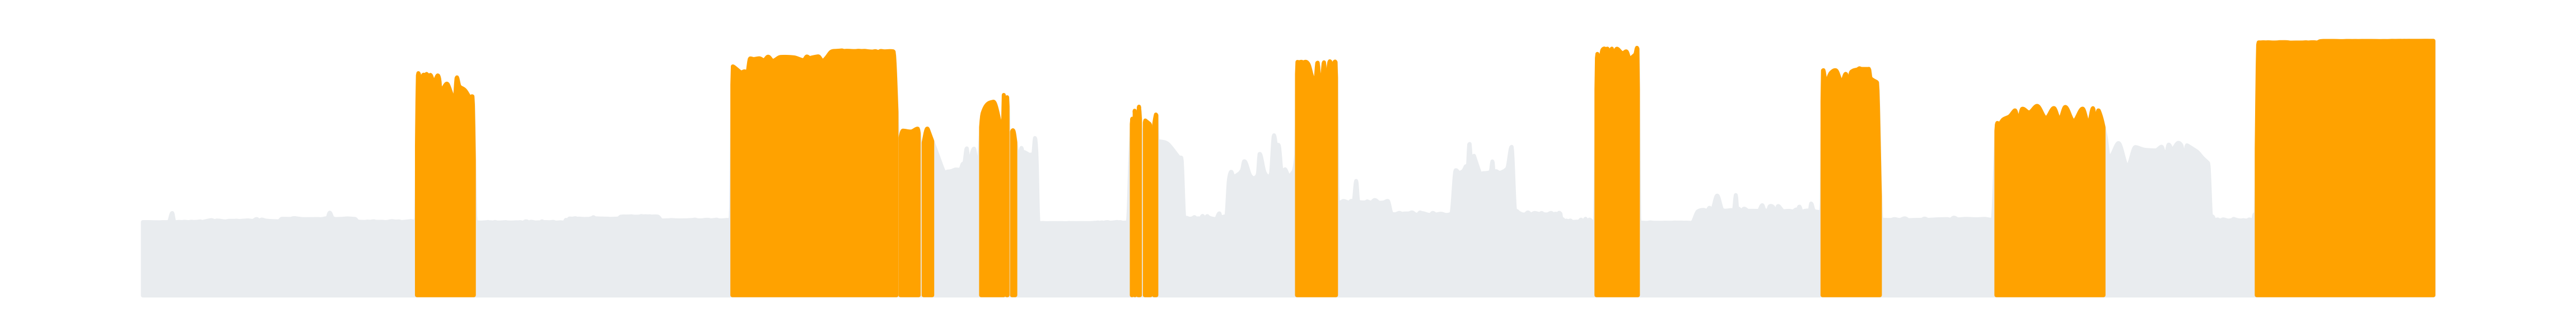

In [90]:
x_axis, interp_pred = interpVidPred(vid_pred, series = '24', season = 'S07', episode = 'E22')
pred_bins = get_intervals_from_pred(vid_pred, series='24', season='S07', episode='E22', thresh = 0.55)
pred_bins = [[b,e] for b, e in zip(pred_bins['beg'], pred_bins['end'])]
fig = plot_model_pred_intervals(x_axis, interp_pred, [[x_axis[0], x_axis[-1]]], color='#e9ecef')
_ = plot_model_pred_intervals(x_axis, interp_pred, pred_bins, savefig=True, fig_name='../plots/QA_S07E22.svg', color='#ffa200', fig=fig) #F1935C, f5895c, F8A673

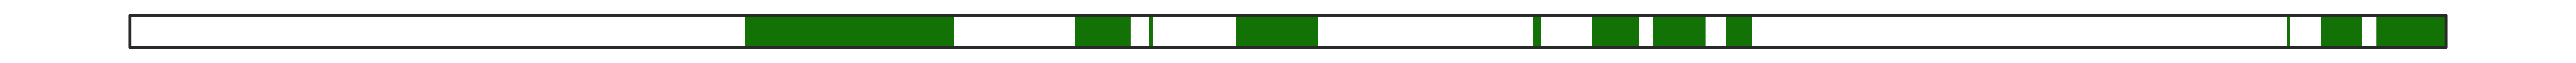

In [91]:
y1 = np.repeat(0, len(x_axis))
y2 = np.repeat(3, len(x_axis))
gt_bins = get_intervals_from_labels(series='24', season='S07', episode='E22', thresh=0.95)
gt_bins = [[b, e] for b, e in zip(gt_bins['beg'], gt_bins['end'])]
_ = plot_intervals(x_axis, y1, y2, gt_bins, savefig=True, fig_name="../plots/QA_S07E22_G.svg", color='#137205') # "FB9F69" "FBB98D" "ff9505"

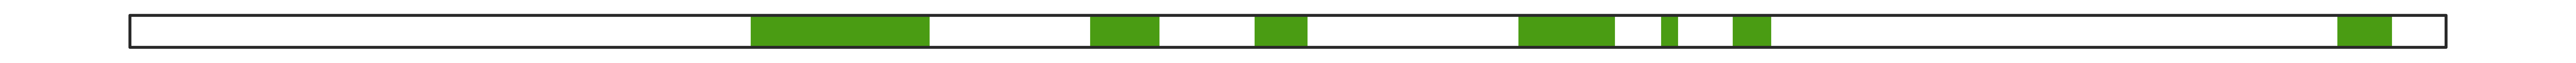

In [92]:
fandom_bins = {'beg': [805.826, 1153.548, 1322.133, 1591.778, 1737.924, 1811.539, 2430.24],
               'end': [987.507, 1222.909, 1374.727, 1689.709, 1753.981, 1849.66, 2485.003]}
fandom_bins = [[b, e] for b, e in zip(fandom_bins['beg'], fandom_bins['end'])]
_ = plot_intervals(x_axis, y1, y2, fandom_bins, savefig=True, fig_name="../plots/QA_S07E22_F.svg", color='#4A9C13')

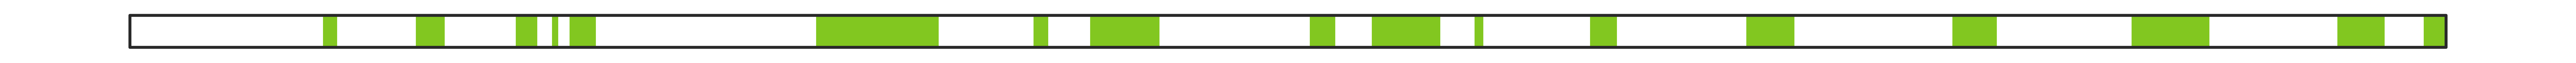

In [93]:
human_bins = {'beg': [367.763, 462.733, 565.252, 602.623, 620.307, 873.143, 1095.699, 1153.548, 1378.523, 1442.003, 1546.983, 1665.268, 1825.47, 2036.722, 2219.864, 2430.24, 2518.787],
              'end': [381.026, 490.886, 586.106, 607.461, 646.125, 996.85, 1109.045, 1222.909, 1403.047, 1510.53, 1554.574, 1691.252, 1873.1, 2080.724, 2297.9, 2477.371, 2539.016]} 
human_bins = [[b, e] for b, e in zip(human_bins['beg'], human_bins['end'])]
_ = plot_intervals(x_axis, y1, y2, human_bins, savefig=True, fig_name="../plots/QA_S07E22_H.svg", color='#82C720')

In [94]:
pred_bins_time = [(sec2time(ele[0]), sec2time(ele[1])) for ele in pred_bins]
print(pred_bins_time)

[('00:07:33', '00:08:33'), ('00:12:60', '00:15:51'), ('00:15:54', '00:16:13'), ('00:16:18', '00:16:28'), ('00:17:17', '00:17:42'), ('00:17:44', '00:17:46'), ('00:17:49', '00:17:53'), ('00:19:54', '00:19:55'), ('00:19:56', '00:19:58'), ('00:19:60', '00:20:02'), ('00:20:07', '00:20:13'), ('00:20:16', '00:20:20'), ('00:22:44', '00:23:26'), ('00:27:54', '00:28:38'), ('00:31:49', '00:32:48'), ('00:34:49', '00:36:40'), ('00:39:18', '00:42:22')]


**S05E21**

In [102]:
# load model predictions...
# r = RoBERTa
eps = "S05E21"
vid_pred = np.load(f"../reports/{eps}_vid_yhat.npy").squeeze()
# vid_pred[vid_pred >= 0.6] -= 0.315
vid_target = np.load(f"../reports/{eps}_vid_targets.npy").squeeze()
dia_pred = np.load(f"../reports/{eps}_dia_yhat.npy").squeeze()
dia_target = np.load(f"../reports/{eps}_dia_targets.npy").squeeze()

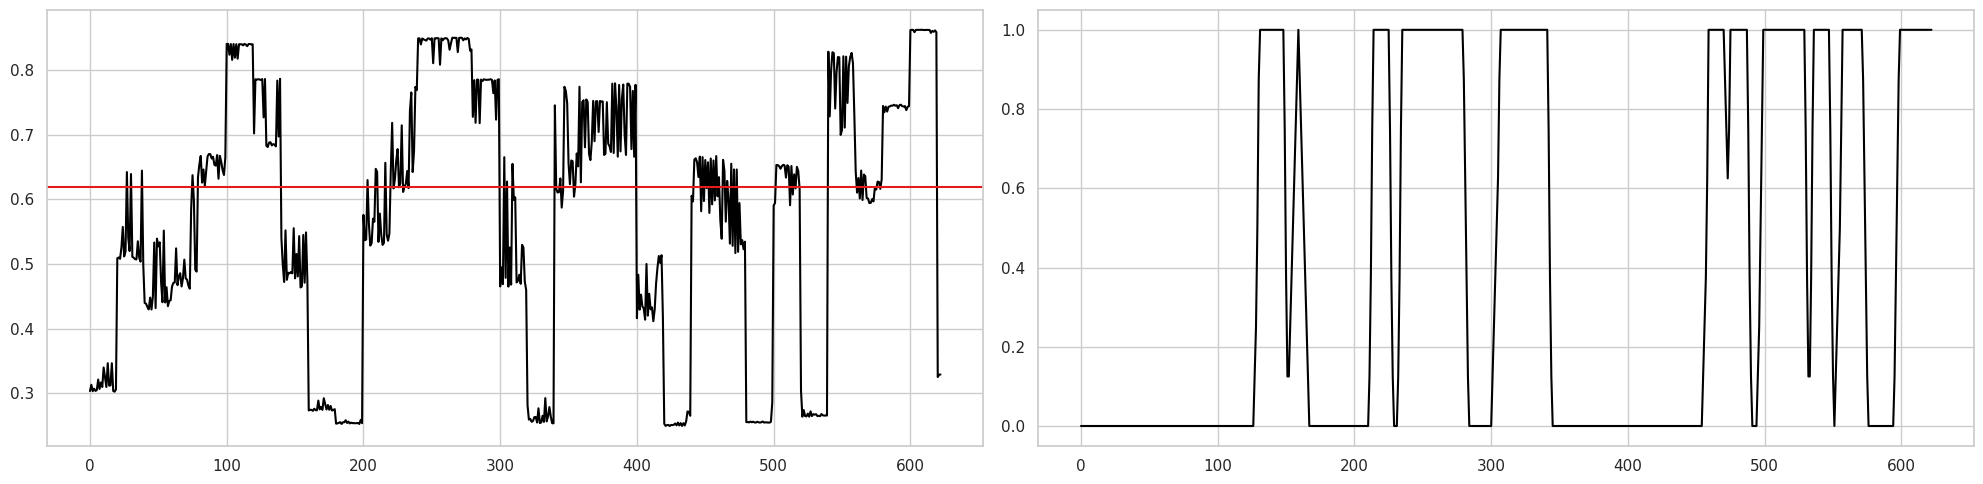

In [103]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))
ax[0].plot(np.arange(len(vid_pred)), vid_pred, color='black'); ax[0].axhline(y=0.62)
ax[1].plot(np.arange(len(vid_target)), vid_target, color='black')
fig.tight_layout()
plt.show()

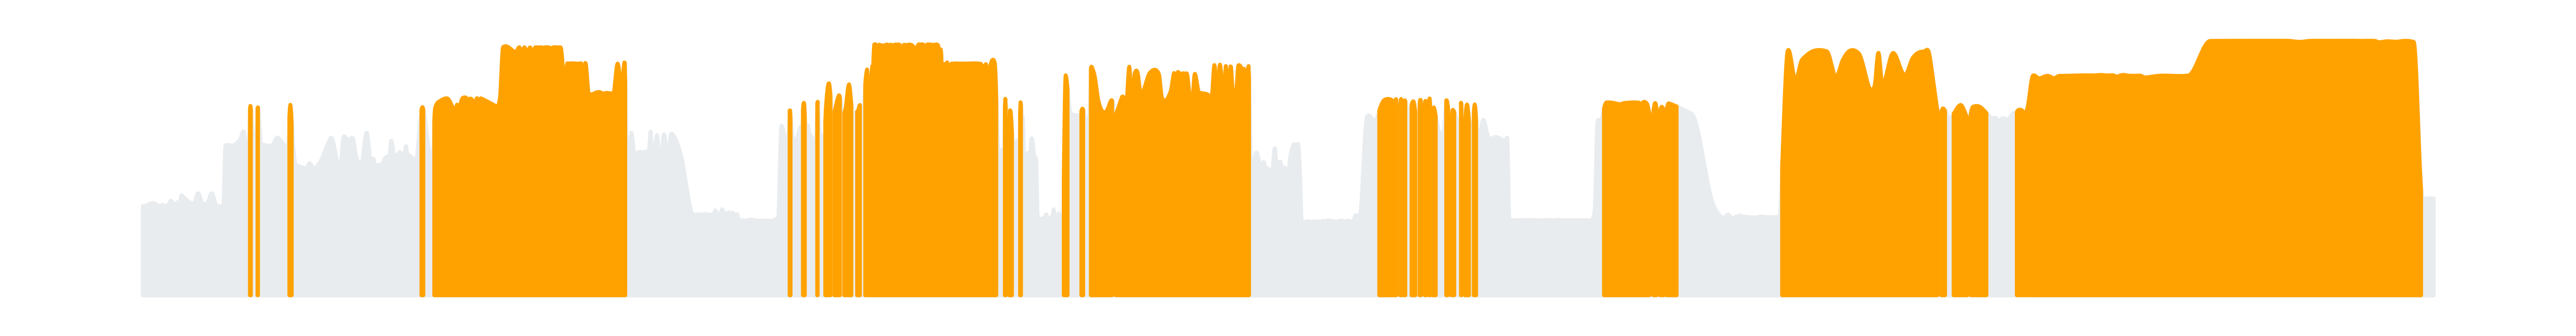

In [104]:
x_axis, interp_pred = interpVidPred(vid_pred, series = '24', season = 'S05', episode = 'E21')
pred_bins = get_intervals_from_pred(vid_pred, series='24', season='S05', episode='E21', thresh = 0.62)
pred_bins = [[b,e] for b, e in zip(pred_bins['beg'], pred_bins['end'])]
fig = plot_model_pred_intervals(x_axis, interp_pred, [[x_axis[0], x_axis[-1]]], color='#e9ecef')
_ = plot_model_pred_intervals(x_axis, interp_pred, pred_bins, savefig=True, fig_name='../plots/QA_S05E21.svg', color='#ffa200', fig=fig) #F1935C, f5895c, F8A673

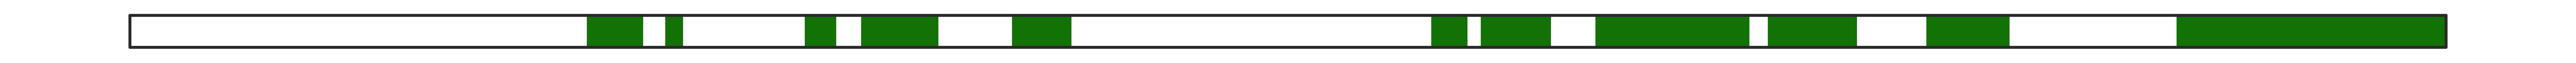

In [98]:
y1 = np.repeat(0, len(x_axis))
y2 = np.repeat(3, len(x_axis))
gt_bins = get_intervals_from_labels(series='24', season='S05', episode='E21', thresh=0.95)
gt_bins = [[b, e] for b, e in zip(gt_bins['beg'], gt_bins['end'])]
_ = plot_intervals(x_axis, y1, y2, gt_bins, savefig=True, fig_name="../plots/QA_S05E21_G.svg", color='#137205') # "FB9F69" "FBB98D" "ff9505"

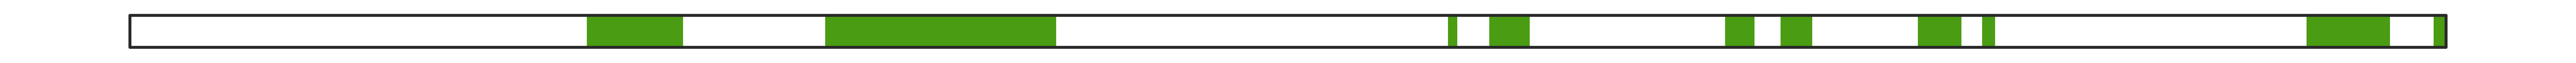

In [99]:
fandom_bins = {'beg': [623.811, 871.809, 1519.998, 1562.957, 1808.578, 1866.219, 2008.903, 2076.012, 2413.641, 2545.856],
               'end': [722.242, 1110.797, 1527.839, 1603.831, 1837.815, 1897.5, 2053.113, 2088.315, 2498.934, 2559.327]}
fandom_bins = [[b, e] for b, e in zip(fandom_bins['beg'], fandom_bins['end'])]
_ = plot_intervals(x_axis, y1, y2, fandom_bins, savefig=True, fig_name="../plots/QA_S05E21_F.svg", color='#4A9C13')

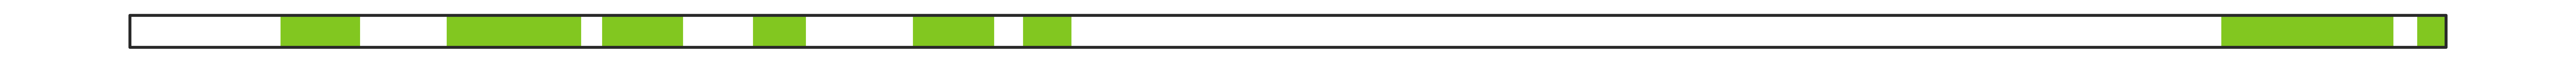

In [100]:
human_bins = {'beg': [304.450, 477.665, 639.785, 796.650, 963.192, 1077.556, 2325.135, 2529.298],
               'end': [385.865, 615.928, 722.242, 850.329, 1046.191, 1126.771, 2502.562, 2559.237]} 
human_bins = [[b, e] for b, e in zip(human_bins['beg'], human_bins['end'])]
_ = plot_intervals(x_axis, y1, y2, human_bins, savefig=True, fig_name="../plots/QA_S05E21_H.svg", color='#82C720')

In [105]:
pred_bins_time = [(sec2time(ele[0]), sec2time(ele[1])) for ele in pred_bins]
print(pred_bins_time)

[('00:04:20', '00:04:21'), ('00:04:28', '00:04:29'), ('00:05:02', '00:05:04'), ('00:07:21', '00:07:23'), ('00:07:34', '00:10:56'), ('00:13:48', '00:13:49'), ('00:14:02', '00:14:04'), ('00:14:17', '00:14:18'), ('00:14:26', '00:14:32'), ('00:14:35', '00:14:42'), ('00:14:46', '00:14:54'), ('00:14:59', '00:15:03'), ('00:15:08', '00:17:26'), ('00:17:34', '00:17:36'), ('00:17:39', '00:17:42'), ('00:17:51', '00:17:52'), ('00:18:37', '00:18:41'), ('00:18:55', '00:18:58'), ('00:19:05', '00:19:28'), ('00:19:31', '00:21:52'), ('00:24:09', '00:24:27'), ('00:24:31', '00:24:33'), ('00:24:35', '00:24:37'), ('00:24:42', '00:24:47'), ('00:24:51', '00:24:53'), ('00:24:56', '00:24:59'), ('00:25:01', '00:25:02'), ('00:25:05', '00:25:09'), ('00:25:19', '00:25:22'), ('00:25:25', '00:25:28'), ('00:25:34', '00:25:36'), ('00:25:39', '00:25:44'), ('00:25:48', '00:25:51'), ('00:28:05', '00:28:54'), ('00:28:57', '00:29:01'), ('00:29:04', '00:29:08'), ('00:29:11', '00:29:22'), ('00:31:13', '00:33:57'), ('00:34:00'

#### **Teaser Figures...**

In [32]:
true_recap_time = {'beg': ['5:08', '5:47', '5:39', '35:42', '36:09', '7:54', '8:27', '14:17', '36:53', '30:28',
                           '30:33', '30:47', '30:53', '18:30', '18:56', '20:07', '20:45', '20:52', '24:54', '25:05',
                           '39:07', '39:24', '40:31', '41:11', '40:59', '41:29', '42:02'],
                   'end': ['5:13', '5:50', '5:44', '35:44', '36:21', '8:11', '8:34', '14:27', '37:10', '30:30',
                           '30:40', '30:49', '31:01', '18:35', '18:58', '20:10', '20:46', '20:58', '25:01', '25:08',
                           '39:10', '39:27', '40:37', '41:16', '41:04', '41:33', '42:08']}
true_recap_time = pd.DataFrame(true_recap_time, columns=['beg', 'end'])
# convert to seconds
true_recap_time['beg'] = true_recap_time['beg'].apply(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]))
true_recap_time['end'] = true_recap_time['end'].apply(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]))
true_recap_time['duration'] = true_recap_time['end'] - true_recap_time['beg']
# check if end time is greater than beg time
print(true_recap_time['duration'].apply(lambda x: x>= 0).all())
true_recap_time.head()

True


,beg,end,duration
0,308,313,5
1,347,350,3
2,339,344,5
3,2142,2144,2
4,2169,2181,12


In [33]:
# Would create bins from the beginining and end time.
bins = true_recap_time[['beg', 'end']].values
x_axis = np.arange(120, 60*43 + 10, 1)
y1 = np.repeat(0, len(x_axis))
y2 = np.repeat(3, len(x_axis))

In [34]:
mrs_interval = get_intervals_from_labels(series='24', season='S08', episode='E22')
mrs_interval = [[b,e] for b, e in zip(mrs_interval['beg'], mrs_interval['end'])]

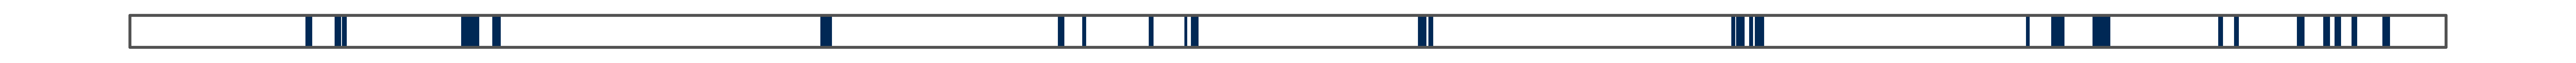

In [35]:
# fig = plot_intervals(x_axis, y1, y2, [[x_axis[0], x_axis[-1]]], savefig=False, color="#caf0f8")#d8f3dc
_ = plot_intervals(x_axis, y1, y2, bins, savefig=True, fig_name="../plots/recap_timeline.svg", color='#002855')#081c15, fig=fig, 

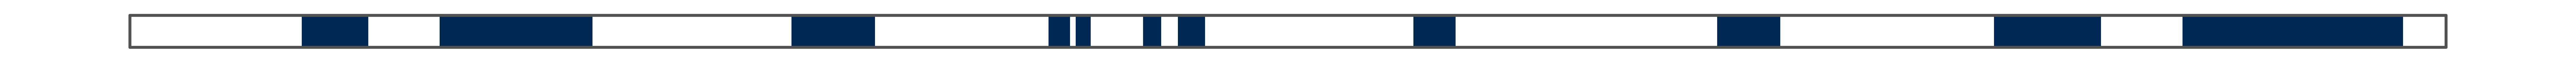

In [36]:
# fig = plot_intervals(x_axis, y1, y2, mrs_interval, savefig=False)
# _ = plot_intervals(x_axis, y1, y2, bins, savefig=False, fig_name="../plots/eps_timeline.svg", fig=fig, color='#fb8500')
# fig = plot_intervals(x_axis, y1, y2, [[x_axis[0], x_axis[-1]]], savefig=False, color="#caf0f8")
_ = plot_intervals(x_axis, y1, y2, mrs_interval, savefig=True, fig_name="../plots/eps_timeline.svg", color='#002855')#, fig=fig

In [64]:
# true_recap_time.sort_values(by=['beg'])

##### CMD special function...

In [10]:
def interpVidPredCMD(vid_model_preds, series:str = 'CMD', season:str = 'AAB'):
    # Extract video time
    shot_obj = load_pickle(f"../data/{series}/{season}/encodings/vid_encodings/episode_OBJ.pkl")
    time_arr = np.array([time2secs(shot_obj[0].time[0])] + \
                        [np.mean(list(map(time2secs, shot_obj[t].time))) for t in range(len(shot_obj))] + \
                        [time2secs(shot_obj[-1].time[-1])])

    xs = np.arange(time_arr[0], time_arr[-1], 0.5)
    # video model predictions
    vid_model_preds = np.hstack((vid_model_preds[0], vid_model_preds, vid_model_preds[-1]))
    # cs = interp1d(time_arr, vid_model_preds, kind="cubic")
    # cs = CubicSpline(time_arr, vid_model_preds) # same as interp1d kind = 'cubic'
    cs = Akima1DInterpolator(time_arr, vid_model_preds)
    interpolated_vals = cs(xs)
    return xs[1:-1], interpolated_vals[1:-1]


def get_intervals_from_predCMD(pred_arr, series='CMD', season='AAB', thresh = 0.85):
    # import vid smooth labels and get the time interval of video shot...
    shot_obj = load_pickle(f"../data/{series}/{season}/encodings/vid_encodings/episode_OBJ.pkl")

    beg_idx_ones, end_idx_ones = getSegsFromOnes((pred_arr.squeeze() > thresh).astype(np.int32))
    vid_smooth_intervals = stitch_intervals(beg_idx_ones, end_idx_ones, shot_obj)
    return vid_smooth_intervals

def plot_model_pred_intervals(x, y1, bins, savefig=False, fig_name='test.svg', color='#023047', fig=None):
    x_patch = find_interval(x, bins)
    if fig is None:
        fig = plt.figure(figsize=(9, 1), dpi=500)
    plt.plot(x, y1, linewidth=0.0)# color='white', 
    plt.fill_between(x, y1, where=x_patch, color=color) # alpha=0.5, edgecolor=None, linewidth=0.0, facecolor="none", hatch="X", 
    # remove ticks, labels, etc. and axes
    # plt.xticks([])
    plt.yticks([])
    # plt.axis('off')
    # fig.legend(['y1', 'y2', 'bins'], loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.5))
    if savefig:
        fig.savefig(fig_name, bbox_inches='tight', pad_inches=0, transparent=True)
    # fig.tight_layout(rect=[0, 0, 0.97, 1])
    fig.tight_layout(pad=0)
    if fig is None:
        plt.show()
    # fig.clear()
    # plt.close()
    return fig

def timeSeg2LabelsCMD(time_start: List[float],
                   time_end: List[float],
                   series_name: str = 'CMD',
                   season: str = 'AAB',
                   inclusion_strategy: str = "mid",
                  ) -> np.ndarray:
    """
    Given a list of start and end times, returns shot-level labels
    or utterance-level labels for respective modality.
    -----------------------------------------------
    Args:
        - time_start: list of start times
        - time_end: list of end times
        - series_name: name of the series
        - season: name of the season, e.g. S01
        - inclusion_strategy: strategy to include the time segment
            - `mid`: include the segment if the mid-point of the segment is
              within the time interval
            - `end`: include the segment if the end of the segment is within
              the time interval
    
    Returns:
        - labels: array of labels
    """
    shot_obj = load_pickle(f"../data/{series_name}/{season}/" +
                           "encodings/vid_encodings/episode_OBJ.pkl")
    labels = np.zeros(len(shot_obj))
    k = 0
    for i, j in zip(time_start, time_end):
        if inclusion_strategy == "end":
            while k < len(shot_obj) and time2secs(shot_obj[k].time[1]) < i:
                k += 1
            while k < len(shot_obj) and time2secs(shot_obj[k].time[1]) <= j:
                # order of conditions is important as the second
                # condition is not checked if the first is false
                labels[k] = 1
                k += 1
        elif inclusion_strategy == "mid":
            while k < len(shot_obj) and np.mean(list(map(time2secs, shot_obj[k].time))) < i:
                k += 1
            while k < len(shot_obj) and np.mean(list(map(time2secs, shot_obj[k].time))) <= j:
                labels[k] = 1
                k += 1
    return labels

#### Computing Metrics (AP) for CMD (model generated v/s human-annotated)

In [15]:
# Movies: AAB, AUL, TKK, TTE, WHS
human_time = load_yaml("../scratch/configs/human_annot_CMD.yaml")['CMD']
movies = ['AAB', 'AUL', 'TTE', 'TKK', 'WHS']
f = open("../reports/CMD_Scores.txt", "w")
f.write("MovieName AP F1\n")
for m in movies:
    start_time = human_time[m]['beg']
    end_time = human_time[m]['end']
    gt_labels = timeSeg2LabelsCMD(start_time, end_time, season=m)
    pred_labels = np.load(f"../reports/{m}_vid_yhat.npy").squeeze()
    try:
        scores = getScores([gt_labels], [pred_labels])
    except TypeError:
        import ipdb; ipdb.set_trace()
    f.write(f"{m} {scores[0]*100:.3f} {scores[1]*100:.3f}\n")
f.close()

#### **AAB**

In [8]:
vid_pred = np.load(f"../reports/AAB_vid_yhat.npy").squeeze()
# vid_pred[vid_pred >= 0.6] -= 0.315
dia_pred = np.load(f"../reports/AAB_dia_yhat.npy").squeeze()
# dia_pred = np.load(f"../reports/{eps}_diar_yhat.npy").squeeze()
# dia_target = np.load(f"../reports/{eps}_diar_targets.npy").squeeze()

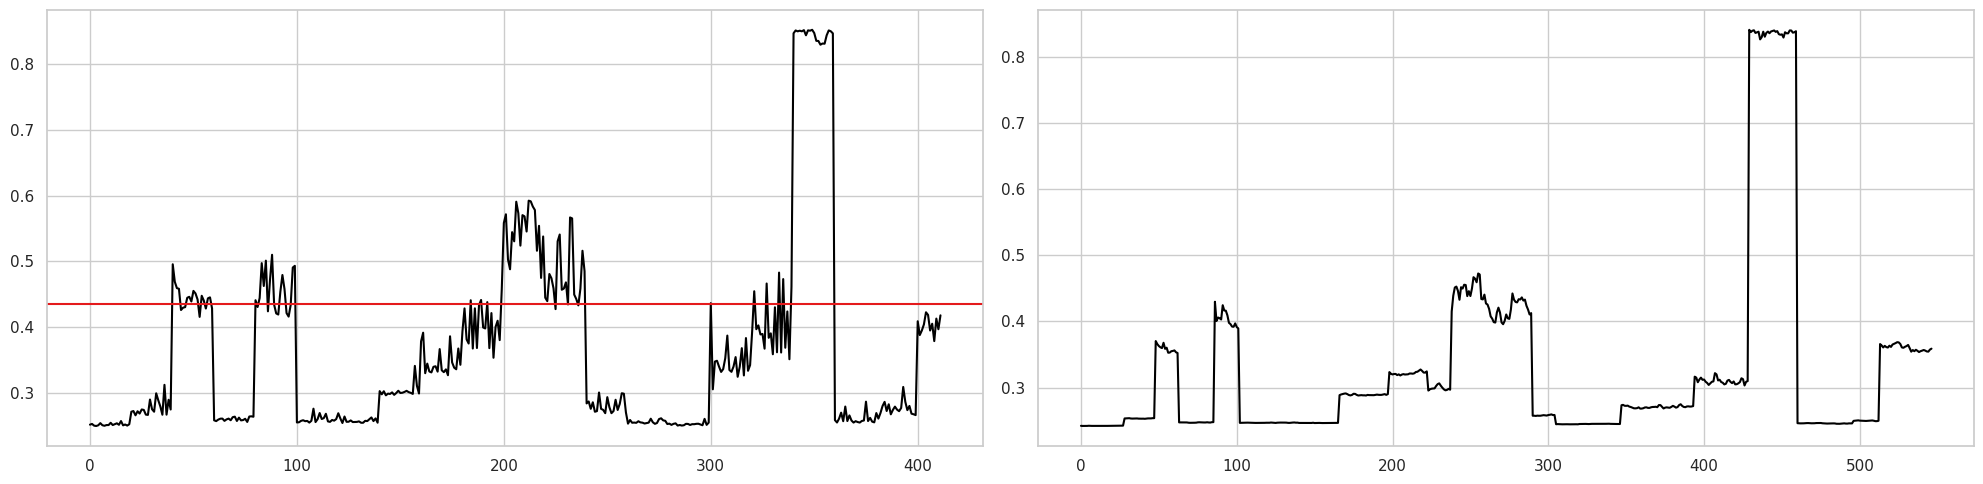

In [28]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))
ax[0].plot(np.arange(len(vid_pred)), vid_pred, color='black')
ax[0].axhline(y=0.435)
ax[1].plot(np.arange(len(dia_pred)), dia_pred, color='black')
fig.tight_layout()
plt.show()

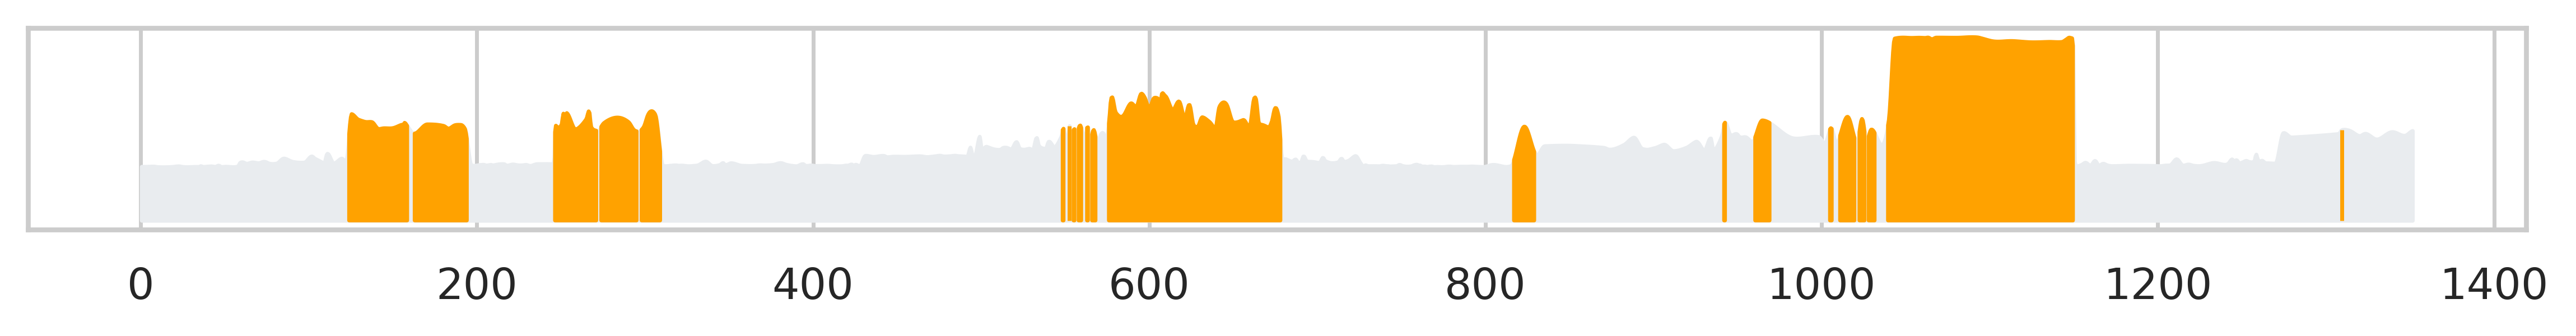

In [29]:
x_axis, interp_pred = interpVidPredCMD(vid_pred, series = 'CMD', season = 'AAB')
pred_bins = get_intervals_from_predCMD(vid_pred, series='CMD', season='AAB', thresh = 0.42)
pred_bins = [[b,e] for b, e in zip(pred_bins['beg'], pred_bins['end'])]
fig = plot_model_pred_intervals(x_axis, interp_pred, [[x_axis[0], x_axis[-1]]], color='#e9ecef')
_ = plot_model_pred_intervals(x_axis, interp_pred, pred_bins, savefig=False, fig_name='../plots/QA_AAB.svg', color='#ffa200', fig=fig) #F1935C, f5895c, F8A673

In [32]:
ttime = sum([b-a for a, b in pred_bins])
print(f"Total time of predicted stuff = {ttime} secs")
print(f"In minutes = {ttime//60}-{ttime%60:.3f}: mins-secs")

Total time of predicted stuff = 388.78300000000024 secs
In minutes = 6.0-28.783: mins-secs


#### **AUL**

In [33]:
vid_pred = np.load(f"../reports/AUL_vid_yhat.npy").squeeze()
# vid_pred[vid_pred >= 0.6] -= 0.315
dia_pred = np.load(f"../reports/AUL_dia_yhat.npy").squeeze()
# dia_pred = np.load(f"../reports/{eps}_diar_yhat.npy").squeeze()
# dia_target = np.load(f"../reports/{eps}_diar_targets.npy").squeeze()

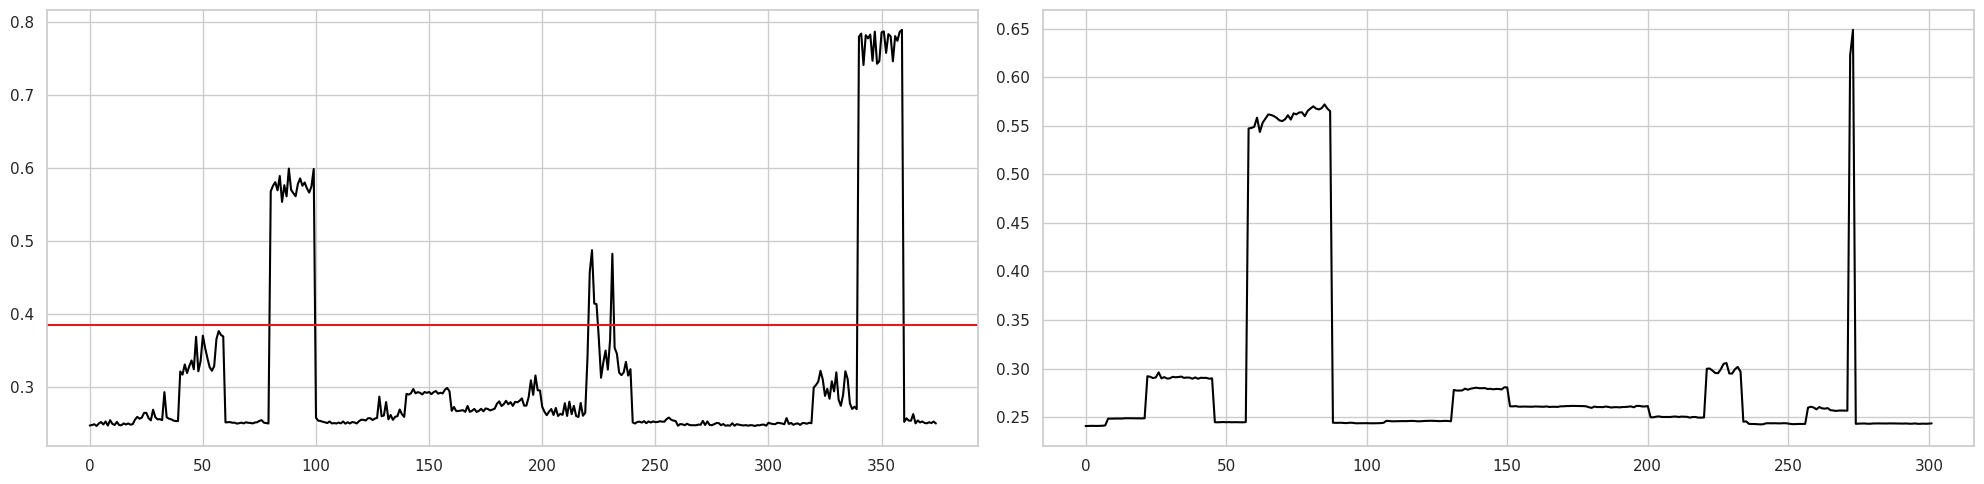

In [37]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))
ax[0].plot(np.arange(len(vid_pred)), vid_pred, color='black')
ax[0].axhline(y=0.385)
ax[1].plot(np.arange(len(dia_pred)), dia_pred, color='black')
fig.tight_layout()
plt.show()

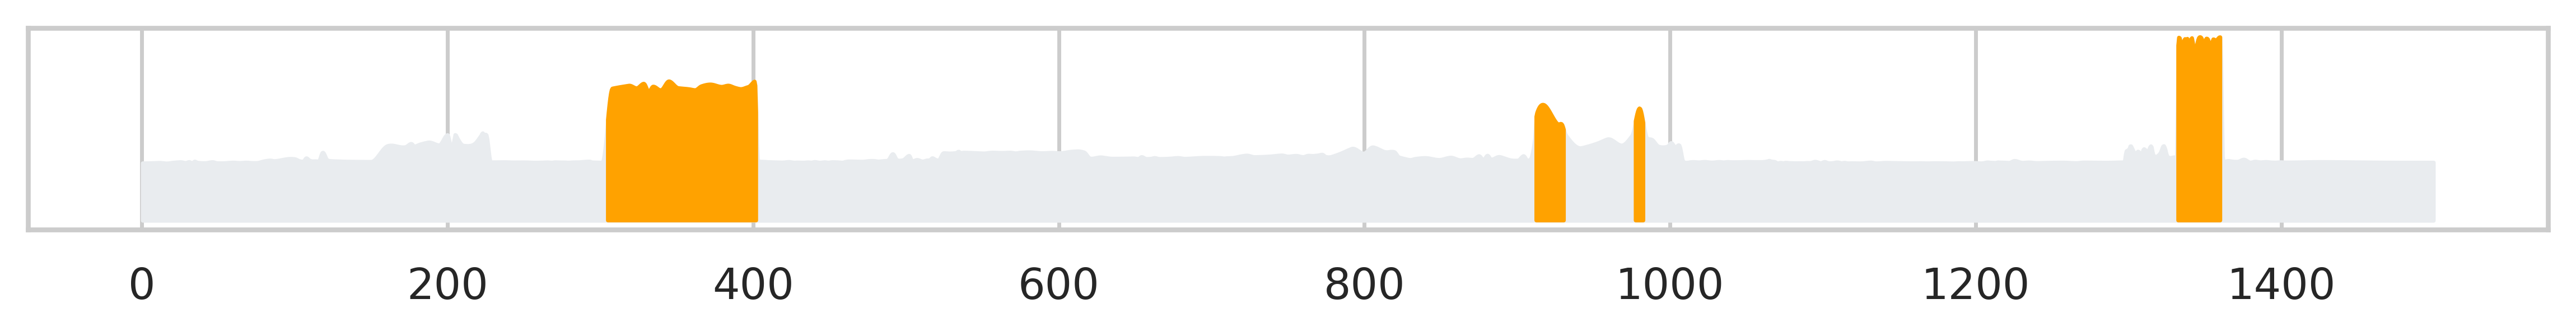

In [38]:
x_axis, interp_pred = interpVidPredCMD(vid_pred, series = 'CMD', season = 'AUL')
pred_bins = get_intervals_from_predCMD(vid_pred, series='CMD', season='AUL', thresh = 0.385)
pred_bins = [[b,e] for b, e in zip(pred_bins['beg'], pred_bins['end'])]
fig = plot_model_pred_intervals(x_axis, interp_pred, [[x_axis[0], x_axis[-1]]], color='#e9ecef')
_ = plot_model_pred_intervals(x_axis, interp_pred, pred_bins, savefig=False, fig_name='../plots/QA_AUL.svg', color='#ffa200', fig=fig) #F1935C, f5895c, F8A673

In [39]:
ttime = sum([b-a for a, b in pred_bins])
print(f"Total time of predicted stuff = {ttime} secs")
print(f"In minutes = {ttime//60}-{ttime%60:.3f}: mins-secs")

Total time of predicted stuff = 149.41599999999983 secs
In minutes = 2.0-29.416: mins-secs


#### **TKK**

In [40]:
vid_pred = np.load(f"../reports/TKK_vid_yhat.npy").squeeze()
# vid_pred[vid_pred >= 0.6] -= 0.315
dia_pred = np.load(f"../reports/TKK_dia_yhat.npy").squeeze()
# dia_pred = np.load(f"../reports/{eps}_diar_yhat.npy").squeeze()
# dia_target = np.load(f"../reports/{eps}_diar_targets.npy").squeeze()

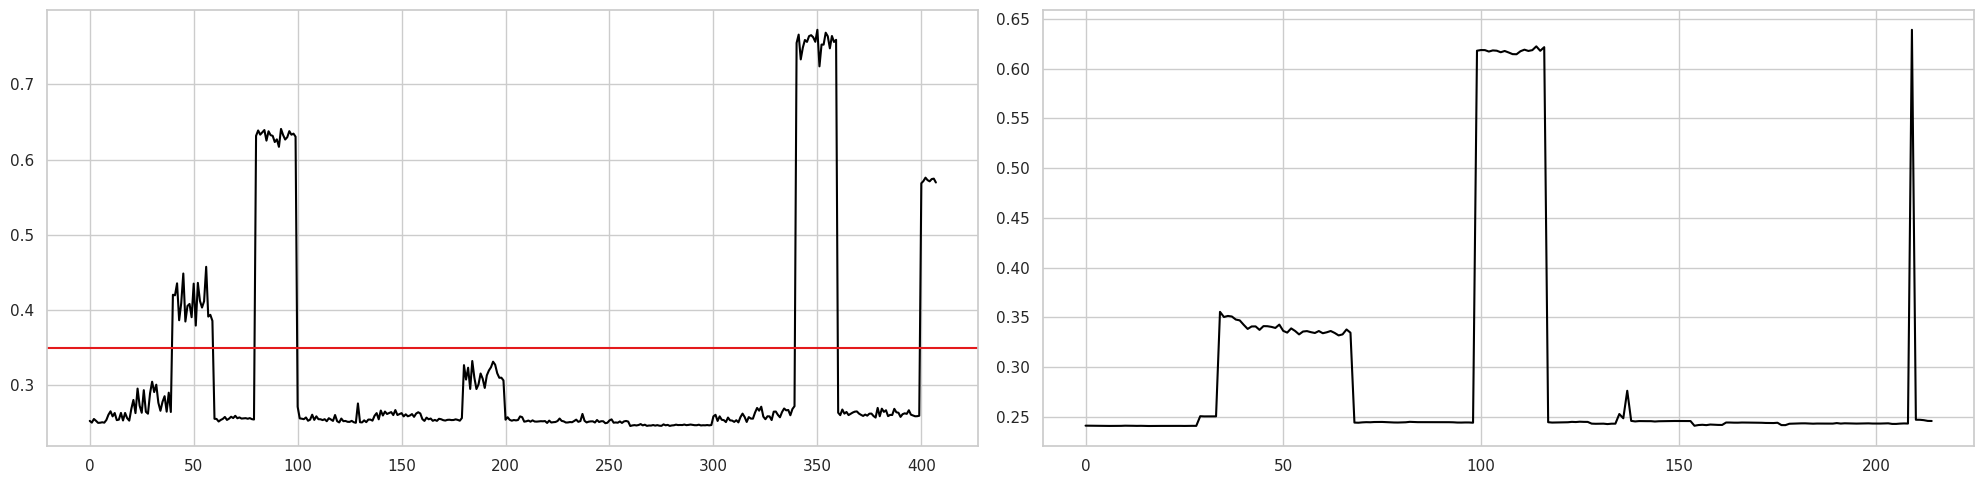

In [42]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))
ax[0].plot(np.arange(len(vid_pred)), vid_pred, color='black')
ax[0].axhline(y=0.35)
ax[1].plot(np.arange(len(dia_pred)), dia_pred, color='black')
fig.tight_layout()
plt.show()

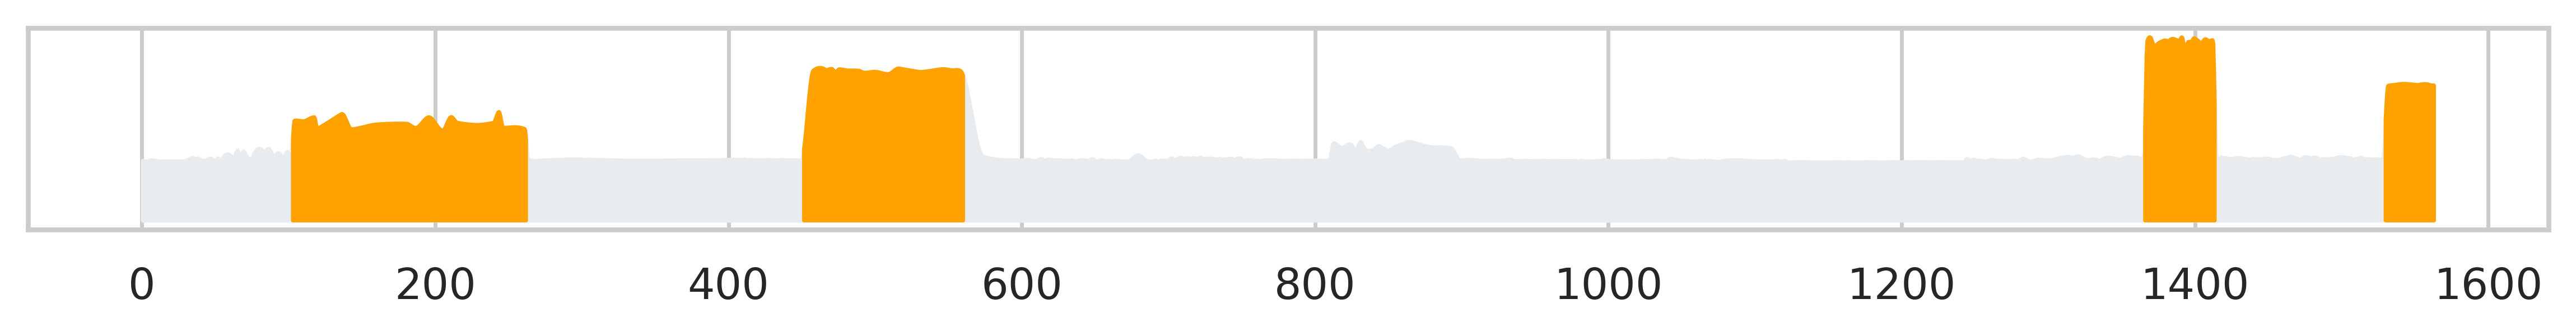

In [43]:
x_axis, interp_pred = interpVidPredCMD(vid_pred, series = 'CMD', season = 'TKK')
pred_bins = get_intervals_from_predCMD(vid_pred, series='CMD', season='TKK', thresh = 0.35)
pred_bins = [[b,e] for b, e in zip(pred_bins['beg'], pred_bins['end'])]
fig = plot_model_pred_intervals(x_axis, interp_pred, [[x_axis[0], x_axis[-1]]], color='#e9ecef')
_ = plot_model_pred_intervals(x_axis, interp_pred, pred_bins, savefig=False, fig_name='../plots/QA_TKK.svg', color='#ffa200', fig=fig) #F1935C, f5895c, F8A673

In [44]:
ttime = sum([b-a for a, b in pred_bins])
print(f"Total time of predicted stuff = {ttime} secs")
print(f"In minutes = {ttime//60}-{ttime%60:.3f}: mins-secs")

Total time of predicted stuff = 350.25000000000017 secs
In minutes = 5.0-50.250: mins-secs


#### **TTE**

In [45]:
vid_pred = np.load(f"../reports/TTE_vid_yhat.npy").squeeze()
# vid_pred[vid_pred >= 0.6] -= 0.315
dia_pred = np.load(f"../reports/TTE_dia_yhat.npy").squeeze()
# dia_pred = np.load(f"../reports/{eps}_diar_yhat.npy").squeeze()
# dia_target = np.load(f"../reports/{eps}_diar_targets.npy").squeeze()

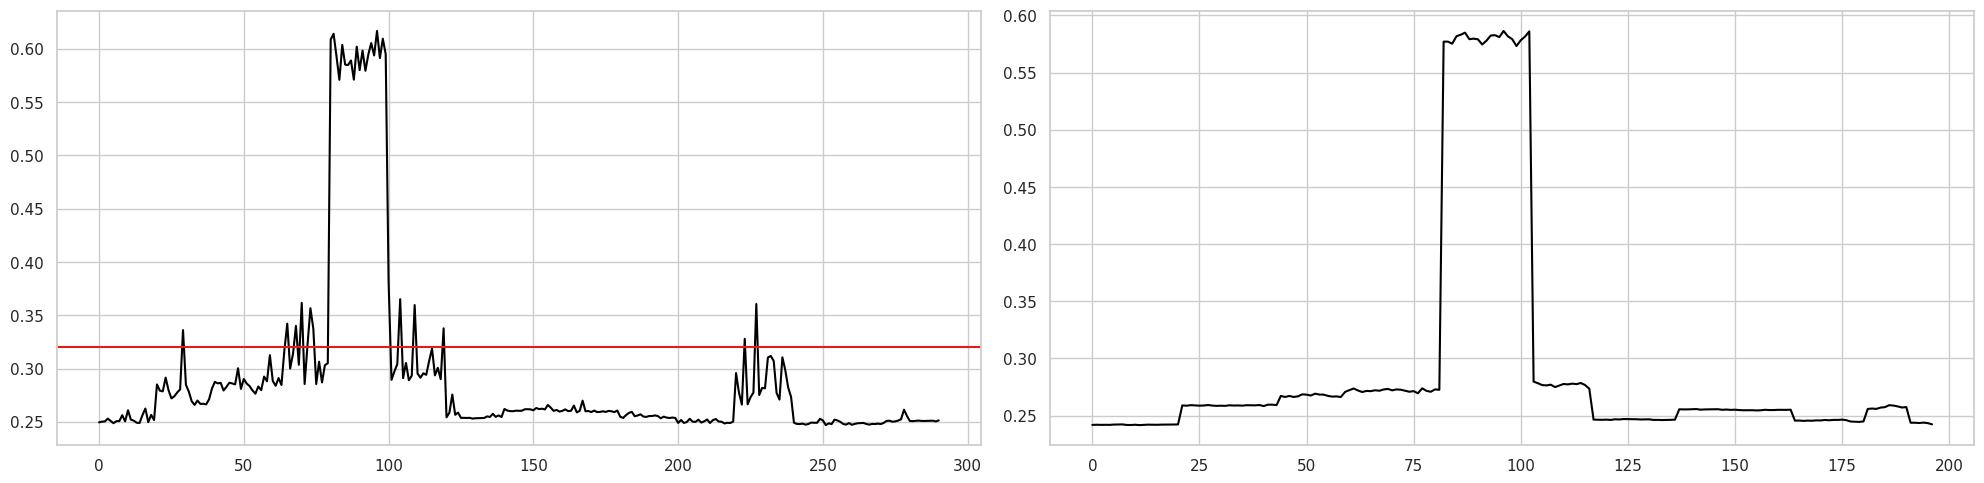

In [47]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))
ax[0].plot(np.arange(len(vid_pred)), vid_pred, color='black')
ax[0].axhline(y=0.32)
ax[1].plot(np.arange(len(dia_pred)), dia_pred, color='black')
fig.tight_layout()
plt.show()

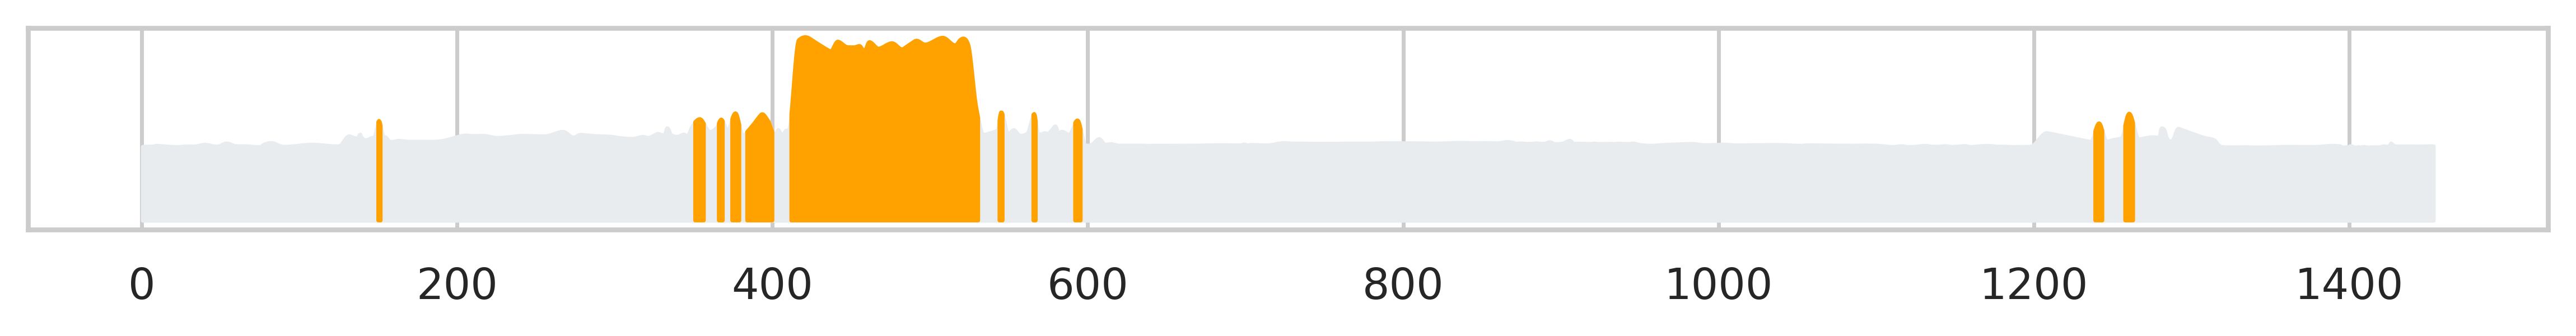

In [48]:
x_axis, interp_pred = interpVidPredCMD(vid_pred, series = 'CMD', season = 'TTE')
pred_bins = get_intervals_from_predCMD(vid_pred, series='CMD', season='TTE', thresh = 0.32)
pred_bins = [[b,e] for b, e in zip(pred_bins['beg'], pred_bins['end'])]
fig = plot_model_pred_intervals(x_axis, interp_pred, [[x_axis[0], x_axis[-1]]], color='#e9ecef')
_ = plot_model_pred_intervals(x_axis, interp_pred, pred_bins, savefig=False, fig_name='../plots/QA_TTE.svg', color='#ffa200', fig=fig) #F1935C, f5895c, F8A673

In [49]:
ttime = sum([b-a for a, b in pred_bins])
print(f"Total time of predicted stuff = {ttime} secs")
print(f"In minutes = {ttime//60}-{ttime%60:.3f}: mins-secs")

Total time of predicted stuff = 170.22300000000016 secs
In minutes = 2.0-50.223: mins-secs


#### **WHS**

In [51]:
vid_pred = np.load(f"../reports/WHS_vid_yhat.npy").squeeze()
# vid_pred[vid_pred >= 0.6] -= 0.315
dia_pred = np.load(f"../reports/WHS_dia_yhat.npy").squeeze()
# dia_pred = np.load(f"../reports/{eps}_diar_yhat.npy").squeeze()
# dia_target = np.load(f"../reports/{eps}_diar_targets.npy").squeeze()

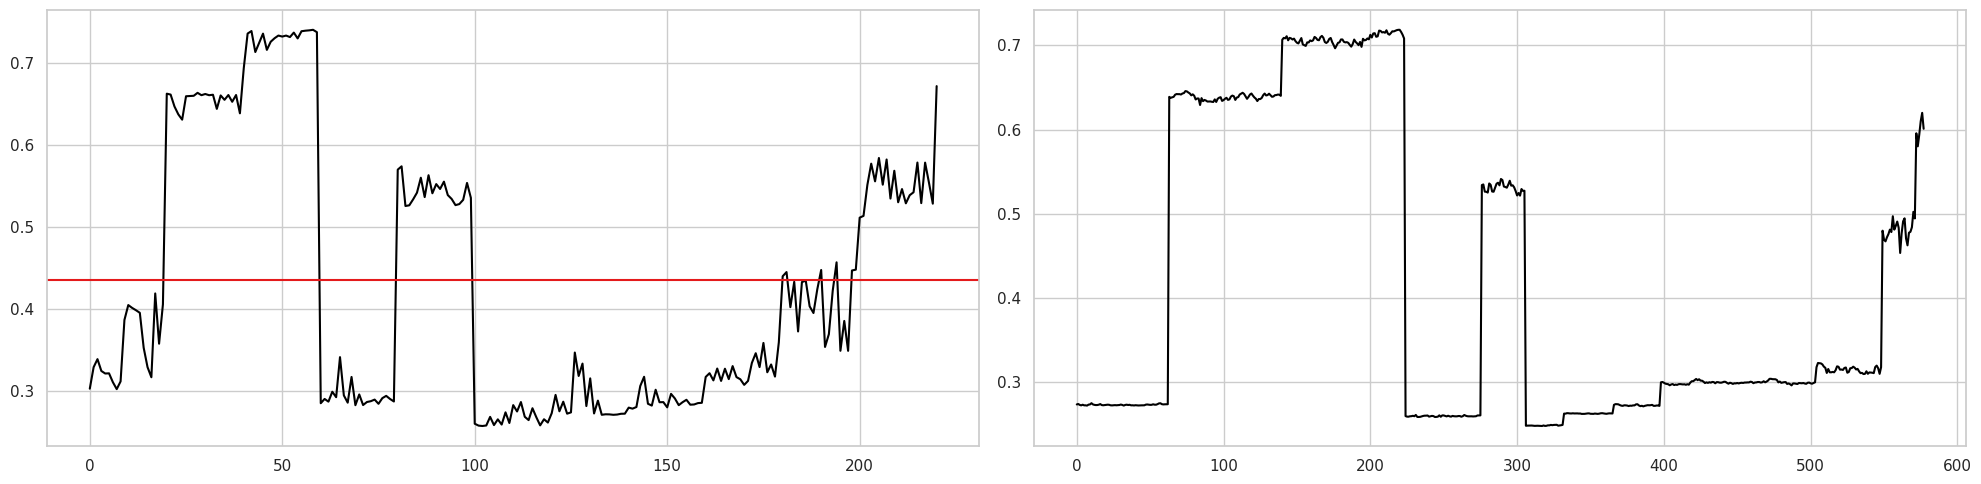

In [52]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))
ax[0].plot(np.arange(len(vid_pred)), vid_pred, color='black')
ax[0].axhline(y=0.435)
ax[1].plot(np.arange(len(dia_pred)), dia_pred, color='black')
fig.tight_layout()
plt.show()

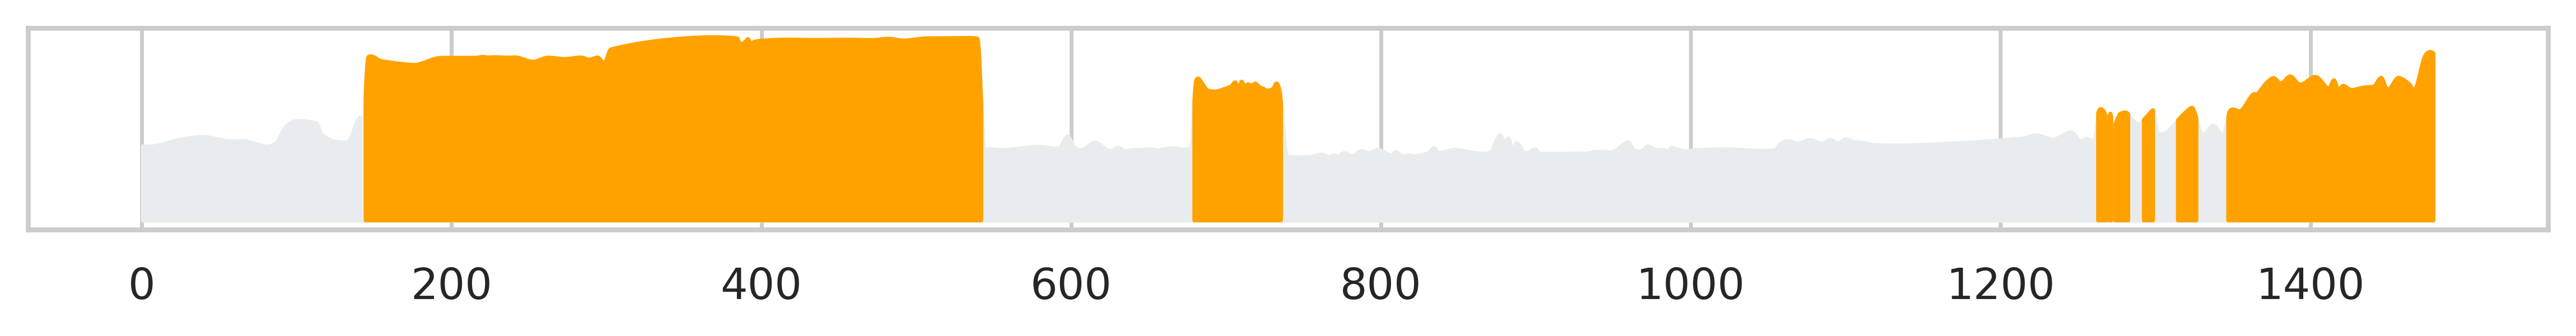

In [53]:
x_axis, interp_pred = interpVidPredCMD(vid_pred, series = 'CMD', season = 'WHS')
pred_bins = get_intervals_from_predCMD(vid_pred, series='CMD', season='WHS', thresh = 0.42)
pred_bins = [[b,e] for b, e in zip(pred_bins['beg'], pred_bins['end'])]
fig = plot_model_pred_intervals(x_axis, interp_pred, [[x_axis[0], x_axis[-1]]], color='#e9ecef')
_ = plot_model_pred_intervals(x_axis, interp_pred, pred_bins, savefig=False, fig_name='../plots/QA_WHS.svg', color='#ffa200', fig=fig) #F1935C, f5895c, F8A673

In [54]:
ttime = sum([b-a for a, b in pred_bins])
print(f"Total time of predicted stuff = {ttime} secs")
print(f"In minutes = {ttime//60}-{ttime%60:.3f}: mins-secs")

Total time of predicted stuff = 622.9780000000002 secs
In minutes = 10.0-22.978: mins-secs
